# Topic modeling using EHR
- Apply a Topic Modeling analysis to uncover the underlying factors for a given medical condition. 
- Each txt file contains pertinent sections such as the Chief Complaint and History of Present Illnesses which are the focal point of this exercise. 
- Accompanying each file are annotations representing the output of a named entity recognition process. This should help compliment the factors found during the topic modeling analysis. 


In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from wordcloud import WordCloud
import pickle

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

In [154]:
# load one file
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load all the files in a directory
def process_docs(directory):
    filenames = list()
    docs = list()
    for filename in listdir(directory):
        path = directory + '/' + filename
        # load document
        filenames.append(filename)
        docs.append(load_doc(path))
    print('Loaded %d files' % len(filenames))
    return filenames, docs

# load both txt and ann files and put them in a dataframe sorted by id
def build_df(directory):
    filenames,docs = process_docs(directory)
    df = pd.DataFrame(list(zip(filenames, docs)), columns=['filename','content'])
    df['id'] = df.filename.apply(lambda x: x.split('.')[0])
    df['ext'] = df.filename.apply(lambda x: x.split('.')[1])
    df = df.pivot(index='id',columns='ext')
    df.columns = ['filename_ann','filename_txt','content_ann','content_txt']
    df = df.reset_index()
    df = df.sort_values(by=['id'],ignore_index=True)
    return df

# text cleaning
# Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove line breaks.
def clean_text(text):
    text = text.lower() #Make text lowercase
    text = re.sub(r'\[.*?\]', ' ', text) #remove text in square brackets,
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text) #remove punctuation
    text = re.sub(r'\w*\d\w*', ' ', text) #remove words containing numbers
    text = re.sub(r'\n', ' ', text) #remove line breaks
    return text

# text lemmatization
nlp = spacy.load('en')
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    output = " ".join(sent)
    output = re.sub('-PRON-', '', output)
    return output

# preprocess text, cleaning and lemmatization
def text_preprocess(text):
    text_clean = clean_text(text)
    text_lemmatized = lemmatizer(text_clean)
    return text_lemmatized

# create a new column with preprocessed text
def column_preprocess(df, col):
    data_list = df[col].values.tolist()
    data_lemmatized = [text_preprocess(data) for data in data_list]

    #add the processed content as a new column to the dataframe
    df[col + '_preprocessed'] = data_lemmatized
    return df


# find the potential field names from the original uncleaned text, 
# which were marked with a : at the end of the line
def find_field_names(df, col):
    field_names = set()
    for row in df[col]:
        row_sentences = list(row.split('\n'))
        row_sentences = [sentence for sentence in row_sentences if sentence!='']
        new_field_names = [sentence[:-1] for sentence in row_sentences if sentence[-1]==':']
        field_names = field_names.union(new_field_names)
    field_names = list(field_names)
    
    percent = []
    for field_name in field_names:
        count = 0
        for row in df[col]:
            if field_name in row:
                 count = count+1 
        current_percent = count/df.shape[0]*100
        percent.append(current_percent)
    df = pd.DataFrame(list(zip(field_names, percent)), columns = ['field_name', 'percent'])
    df = df.sort_values('percent',ascending = False,ignore_index=True)
    
    plt.figure(figsize=(20, 4))
    plt.plot(df.percent)
    plt.xlabel('index of stop words')
    plt.ylabel('percentage of  occurance in all the files')
    plt.show()
    return df

# extract content by a keyword
# the content should start at the location where there is keyword:, eg, 'Chief Complaint:'
# It continues search for the next line that has another keyword from a keyword list, or until the end of the file
# the keep the content in between 

KEYWORD_LIST = ['Admission Date', 'Discharge Date', 'Date of Birth', 'Sex','Service', 'Allergies', 'Attending', 
                'Chief Complaint', 'Major Surgical or Invasive Procedure', 'History of Present Illness', 
                'Past Medical History', 'Social History', 'Family History', 'Physical Exam', 
                'Pertinent Results', 'Brief Hospital Course','Medications on Admission', 
                'Discharge Medications', 'Discharge Disposition', 'Facility', 
                'Discharge Diagnosis', 'Discharge Condition', 'Discharge Instructions', 
                'Followup Instructions','PHYSICAL EXAMINATION ON ADMISSION', 'History of the Present Illness',
               'LABORATORY DATA', 'HOSPITAL COURSE', 'DISPOSITION', 'MAJOR PROCEDURES', 'CONDITION ON DISCHARGE',
               'Addendum', 'DISCHARGE SUMMARY ADDENDUM','DISCHARGE DIAGNOSES']

# After comparing the stop_words list from nltk, word cloud and sklearn, 
# slkean has the most extensive list, thus was chosen as the default stop_words list
# then add keyword_list to the stop_words
def default_stop_words():
    stop_words = text.ENGLISH_STOP_WORDS
    keyword_list = [keyword.lower() for keyword in KEYWORD_LIST]
    keyword_list = [text_preprocess(keyword) for keyword in KEYWORD_LIST]
    stop_words = stop_words.union(keyword_list)
    return stop_words

def extract_by_keyword(original_text, keyword):
    # make everything lowercase
    original_lower = original_text.lower()
    
    keyword = keyword.lower()
    if keyword[-1] != ':':
        keyword = keyword + ':'
    
    keyword_list = KEYWORD_LIST
    keyword_list = [keyword.lower() for keyword in keyword_list]
    keyword_list = [keyword + ':' for keyword in keyword_list]

    #split by lines because the beginning of a section always starts from a new line
    t = pd.DataFrame(original_lower.split('\n'))
    t.columns = ['text']

    #fine the index where the line of text contains the keyword immediately followed by :
    content_start_index = t.index[t['text'].str.contains(keyword)].to_list() #The majority of the files
    if content_start_index == [] and 'history of present illness' in keyword:
        content_start_index = t.index[t['text'].str.contains('history of the present illness')].to_list() #accommodating one special case
    if content_start_index == [] and 'discharge diagnosis' in keyword:
        content_start_index = t.index[t['text'].str.contains('discharge diagnoses')].to_list() #accommodating one special case
        
    # if the content_start_index is found, look for content_end_index
    if content_start_index !=[]:
        content_start_index = content_start_index[0]
        content_end_index = 0
        for row_index in range(content_start_index+1,t.shape[0]):
            for akeyword in keyword_list:
                if akeyword in t['text'][row_index]:
                    content_end_index = row_index -1
                    break
            if content_end_index > 0:
                break
        pre_cleaning = ',,'.join(t['text'][content_start_index:content_end_index]) #use ,, to mark the original end of line
        post_cleaning = text_preprocess(pre_cleaning)[(len(keyword)+1):]
    else:
        pre_cleaning = ''
        post_cleaning = ''
    return [pre_cleaning, post_cleaning]
        
def extract_by_keyword_df(df, keyword):
    if keyword[-1] != ':':
        keyword = keyword + ':'
    new_colname = keyword[:-1].lower()
    new_colname = re.sub(' ', '_', new_colname)
    df[new_colname] = df['content_txt'].apply(lambda x: extract_by_keyword(x, keyword)[0])    
    df[new_colname + '_preprocessed'] = df['content_txt'].apply(lambda x: extract_by_keyword(x, keyword)[1])
    n_empty_rows = df[df[new_colname + '_preprocessed']==''].shape[0]
    total_rows = df.shape[0]
    print(keyword, 'total number of rows', total_rows, 'empty rows', n_empty_rows)
    return df

# Extract the first discharge diagnosis
# first get the full text of discharge diagnosis
# then extract either the first line, or the first line of primary (diagnosis)
def extract_first_diagnosis(original_text):
    discharge_diagnosis = extract_by_keyword(original_text, 'discharge diagnosis')[0]
    if discharge_diagnosis == '':
        first_diagnosis = ''
    else:
        discharge_diagnosis = discharge_diagnosis.split(',,')
        first_diagnosis = ''
        if len(discharge_diagnosis) == 1:
            discharge_diagnosis = discharge_diagnosis[0]
            discharge_diagnosis = list(filter(None, discharge_diagnosis.split(' ')))
            if discharge_diagnosis[0].lower()=='discharge':
                discharge_diagnosis.pop(0)
            if discharge_diagnosis[0].lower()=='primary:':
                discharge_diagnosis.pop(0)
            if discharge_diagnosis[0].lower()=='diagnosis:' or discharge_diagnosis[0].lower()=='diagnoses:':
                discharge_diagnosis.pop(0)
            first_diagnosis = ' '.join(discharge_diagnosis)
        else:
            for line in discharge_diagnosis:
                if text_preprocess(line) not in ['discharge diagnosis', 'primary', 'primary diagnosis','discharge diagnoses']:
                    first_diagnosis = line
                    first_diagnosis = re.sub('primary', '', first_diagnosis, flags=re.IGNORECASE)
                    break
    return first_diagnosis

# extract first diagnosis from the dataframe and clean
def extract_first_diagnosis_df_clean(df):

    new_colname = 'first_diagnosis'
    df[new_colname] = df['content_txt'].apply(lambda x: extract_first_diagnosis(x))    
    df[new_colname + '_preprocessed'] = df[new_colname].apply(lambda x: text_preprocess(x))
    n_empty_rows = df[df[new_colname]==''].shape[0]
    total_rows = df.shape[0]
    print('First Diagnosis:', 'total number of rows', total_rows, 'empty rows', n_empty_rows)
    return df

# create a new column that contains potential label for topic generation
# looks takes the following components in order to fill the field
# if it couldn't fill it using the first component, go to the next component 
# first_diagnosis - chief complaint - Service (if it's not 'medicine') -- Addendum
def get_label_candidate(df):
    print('Empty line', df.shape[0])
    df['label_candidate'] = df['first_diagnosis_preprocessed']
    empty_indics = df.index[df['label_candidate']==''].to_list()
    print('Empty line after filling in first_diagnosis', len(empty_indics))
    for index in empty_indics:
        df['label_candidate'][index] = df['chief_complaint_preprocessed'][index]
    empty_indics = df.index[df['label_candidate']==''].to_list()
    print('Empty line after filling in chief_complaint', len(empty_indics))
    for index in empty_indics:
        df['label_candidate'][index] = df['service_preprocessed'][index]
    empty_indics = df.index[df['label_candidate']==''].to_list()
    print('Empty line after filling in service', len(empty_indics))
    #for index in empty_indics:
    #    df['label_candidate'][index] = df['addendum_preprocessed'][index]
    #empty_indics = df.index[df['label_candidate']==''].to_list()
    #print('Empty line after filling in addendum', len(empty_indics))

    return df

#make a word cloud giving the text in a list, and stop words
def make_word_cloud(data_list, stop_words=default_stop_words()):

    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(data_list))
    print(wordcloud)
    fig = plt.figure(1)
    rcParams['figure.figsize']=(12.0,12.0)  
    rcParams['font.size']=12            
    rcParams['savefig.dpi']=100             
    rcParams['figure.subplot.bottom']=.1 
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();
    
#calculate unigram/bigram/trigram with stop_words
def get_top_ngram(data, ngram=1, top_n=None, stop_words=default_stop_words()):
    ngram_names = ['unigram','bigram','trigram']
    ngram_name = ngram_names[ngram-1]
    #calculate unigram
    vec = CountVectorizer(ngram_range = (ngram, ngram), stop_words=stop_words).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:top_n]
    #visulization
    df = pd.DataFrame(common_words, columns = [ngram_name , 'count'])
    fig = go.Figure([go.Bar(x=df[ngram_name], y=df['count'])])
    fig.update_layout(title=go.layout.Title(text="Top " + str(top_n) + ' '+ ngram_name))
    fig.show()

# vectorize the content
def get_data_vectorized(data, stop_words=default_stop_words(), max_features=3000):
    vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                         # minimum requied occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=max_features,             # max number of unique words
                            )

    data_vectorized = vectorizer.fit_transform(data)
    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
    return data_vectorized, vectorizer

def do_vectorization_lda(data, n_components, stop_words, max_features):
    data_vectorized, vectorizer = get_data_vectorized(data, stop_words=default_stop_words(), max_features=3000)
    lda = LatentDirichletAllocation(n_components=n_components,
                                     learning_decay=.7,
                                     batch_size=64,
                                     learning_offset=10,
                                     max_iter=10,
                                     max_doc_update_iter=100)
    lda.fit(data_vectorized)
    lda_output = {}
    lda_output['best_lda_model'] = lda
    lda_output['data_vectorized'] = data_vectorized
    lda_output['vectorizer'] = vectorizer
    return lda_output

# grid search on n_components and learning_decay
def lda_grid(data_vectorized, n_components_list=[10, 15, 20, 25, 30]):
    # Define Search Param
    search_params = {'n_components': n_components_list,
                     'learning_decay': [.7],
                     'batch_size': [64],
                     'learning_offset': [10],
                     'max_iter': [10],
                     'max_doc_update_iter': [100]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(data_vectorized)
    print("Best Model's Params: ", model.best_params_)
    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)
    # Perplexity
    print("Model Perplexity: ", model.best_estimator_.perplexity(data_vectorized))

    return model

# conduct the whole process of vectorization, grid search, and find the best model
def lda_grid_run(data, stop_words=default_stop_words(), n_components_list=[10, 15, 20, 25, 30]):
    data_vectorized, vectorizer = get_data_vectorized(data, stop_words)
    model = lda_grid(data_vectorized, n_components_list);
    lda_output={}
    lda_output['best_lda_model'] = model.best_estimator_
    lda_output['model'] = model
    lda_output['data_vectorized'] = data_vectorized
    lda_output['vectorizer'] = vectorizer
    return lda_output

# create document topic matrix
def get_document_topic_matrix(best_lda_model, data_vectorized):
    # Create Document - Topic Matrix
    lda_output = best_lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(data_vectorized.shape[0])]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    # Apply Style
    df_document_topic_top = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    return df_document_topic, df_document_topic_top, topicnames

    # Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# get_topic_distribution
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    return df_topic_distribution

# get topic_keywords
def get_topic_keywords(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    return topic_keywords, df_topic_keywords

# get topic-keyword matrix
def get_topic_keywords_matrix(lda_model, vectorizer, topicnames):
    df_topic_keywords_matrix = pd.DataFrame(lda_model.components_)

    df_topic_keywords_matrix.columns = vectorizer.get_feature_names()
    df_topic_keywords_matrix.index = topicnames

    return df_topic_keywords_matrix

# get the lda panel for showing
def get_lda_panel(lda_output):
    panel = pyLDAvis.sklearn.prepare(lda_output['best_lda_model'], 
                                     lda_output['data_vectorized'], 
                                     lda_output['vectorizer'], 
                                     mds='tsne')
    return panel

# get several metrics from the lda model
def evalute_lda(lda_output):
    best_lda_model = lda_output['best_lda_model']
    data_vectorized = lda_output['data_vectorized']
    vectorizer = lda_output['vectorizer']
                                            
    df_document_topic, df_document_topic_top, topicnames = get_document_topic_matrix(best_lda_model, data_vectorized)
    df_topic_distribution = get_topic_distribution(df_document_topic)
    topic_keywords, df_topic_keywords = get_topic_keywords(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)
    df_topic_keywords_matrix = get_topic_keywords_matrix(best_lda_model, vectorizer, topicnames)
    lda_metrics = {}
    lda_metrics['df_document_topic'] = df_document_topic
    lda_metrics['df_document_topic_top'] = df_document_topic_top
    lda_metrics['df_topic_distribution'] = df_topic_distribution
    lda_metrics['df_topic_keywords'] = df_topic_keywords
    lda_metrics['df_topic_keywords_matrix'] = df_topic_keywords_matrix
    return lda_metrics

def add_topic_keywords_to_df(df, lda_metrics):
    df_document_topic = lda_metrics['df_document_topic']
    df_document_topic = df_document_topic.reset_index()
    df = df.join(df_document_topic['dominant_topic'])
    df_topic_keywords = lda_metrics['df_topic_keywords']
    label_list = ['Word ' + str(n) for n in range(0,11)]
    df_topic_keywords['top_10_keywords'] = df_topic_keywords[label_list].agg(','.join, axis=1)
    dict_topic_keywords = {}
    for index in df_topic_keywords.index:
        dict_topic_keywords[index] = df_topic_keywords['top_10_keywords'][index]

    df['topic_top_10_keywords'] = df['dominant_topic'].apply(lambda x:dict_topic_keywords['Topic ' + str(x)])
    return df
# make prediction
def predict_topic(data, lda_output, lda_metrics):
    
    if type(data)==str: #single prediction
    # Step 1: Clean with the text
        data_1 = [text_preprocess(data)]
    else: # a list of content to predict
        data_1 = [text_preprocess(row) for row in data]

    # Step 2: Vectorize transform
    data_2 = lda_output['vectorizer'].transform(data_1)

    # Step 3: LDA Transform
    topic_probability_scores = lda_output['best_lda_model'].transform(data_2)
    topic = lda_metrics['df_topic_keywords'].iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores


# 1. Import all the files and build a data frame

In [4]:
#import all the files and build a data frame
df = build_df('training_20180910')

Loaded 606 files


In [157]:
df.head()

id filename_ann filename_txt  \
0  100035   100035.ann   100035.txt   
1  100039   100039.ann   100039.txt   
2  100187   100187.ann   100187.txt   
3  100229   100229.ann   100229.txt   
4  100564   100564.ann   100564.txt   

                                         content_ann  \
0  T1\tReason 10179 10197\trecurrent seizures\nR1...   
1  T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...   
2  T1\tDrug 10017 10032\tanticoagulation\nT2\tDru...   
3  T1\tDuration 1003 1011\tfive-day\nR1\tDuration...   
4  T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...   

                                         content_txt  
0  Admission Date:  [**2115-2-22**]              ...  
1  Admission Date:  [**2174-4-18**]              ...  
2  Admission Date:  [**2107-1-17**]              ...  
3  Admission Date:  [**2114-12-24**]             ...  
4  Admission Date:  [**2144-1-20**]              ...

# 2. Extract components and preprocess text 
## Extracted fields: 
- "Chief Complaint", 
- "History of Present Illness", '
- Discharge Diagnosis", 
- "Service", 
- "Addumdum",
- first line of primary discharge diagnosis

## Preprocess: remove punctuation and lemmatization

In [5]:
# preprocess the full text, takes aboutn 90 seconds
df = column_preprocess(df,'content_txt')

In [6]:
df = extract_by_keyword_df(df, 'Chief Complaint')
df = extract_by_keyword_df(df, 'History of Present Illness')
df = extract_by_keyword_df(df, 'Discharge Diagnosis')
df = extract_first_diagnosis_df_clean(df)
df = extract_by_keyword_df(df, 'Service:')
df = extract_by_keyword_df(df, 'Addendum:')

Chief Complaint: total number of rows 303 empty rows 32
History of Present Illness: total number of rows 303 empty rows 21
Discharge Diagnosis: total number of rows 303 empty rows 23
First Diagnosis: total number of rows 303 empty rows 23
Service: total number of rows 303 empty rows 12
Addendum: total number of rows 303 empty rows 293


In [7]:
# create a column that can serve as a potential label for the file
df = get_label_candidate(df)

Empty line 303
Empty line after filling in first_diagnosis 23
Empty line after filling in chief_complaint 21
Empty line after filling in service 9


In [8]:
df.head()

id filename_ann filename_txt  \
0  100035   100035.ann   100035.txt   
1  100039   100039.ann   100039.txt   
2  100187   100187.ann   100187.txt   
3  100229   100229.ann   100229.txt   
4  100564   100564.ann   100564.txt   

                                         content_ann  \
0  T1\tReason 10179 10197\trecurrent seizures\nR1...   
1  T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...   
2  T1\tDrug 10017 10032\tanticoagulation\nT2\tDru...   
3  T1\tDuration 1003 1011\tfive-day\nR1\tDuration...   
4  T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...   

                                         content_txt  \
0  Admission Date:  [**2115-2-22**]              ...   
1  Admission Date:  [**2174-4-18**]              ...   
2  Admission Date:  [**2107-1-17**]              ...   
3  Admission Date:  [**2114-12-24**]             ...   
4  Admission Date:  [**2144-1-20**]              ...   

                            content_txt_preprocessed  \
0  admission date                   discharge dat...   
1  admission date                   discharge dat...   
2  admission date                   discharge dat...   
3  admission date                   discharge dat...   
4  admission date                   discharge dat...   

                                     chief_complaint  \
0  chief complaint:,,post-cardiac arrest, asthma ...   
1                   chief complaint:,,abdominal pain   
2                              chief complaint:,,sob   
3  chief complaint:,,hypotension with elevated la...   
4                   chief complaint:,,svc thrombosis   

                        chief_complaint_preprocessed  \
0          post cardiac arrest   asthma exacerbation   
1                                     abdominal pain   
2                                                sob   
3    hypotension with elevated lactate   code sepsis   
4                                     svc thrombosis   

                          history_of_present_illness  \
0  history of present illness:,,mr. [**known last...   
1  history of present illness:,,38 yo f w/ h/o al...   
2  history of present illness:,,64 yo woman w/ h/...   
3  history of present illness:,,44 yom pmh esrd s...   
4  history of present illness:,,43 yo male with h...   

             history_of_present_illness_preprocessed  \
0    mr     be a    year old gentleman with a pmh...   
1      yo f w   h o all in remission s p cord tra...   
2      yo woman w   h o recurrent pes s      filt...   
3      yom pmh esrd secondary to brights disease ...   
4      yo male with hx of rectal ca   dmii   and ...   

                                 discharge_diagnosis  \
0  discharge diagnosis:,,anoxic brain injury s/p ...   
1  discharge diagnosis:,,primary:,,-abdominal pai...   
2  discharge diagnosis:,,primary:,,1) pulmonary e...   
3  discharge diagnosis:,,primary:,,1. sepsis,,2. ...   
4  discharge diagnosis:,,1. deep vein thrombosis ...   

                    discharge_diagnosis_preprocessed  \
0    anoxic brain injury s p pea arrest     statu...   
1    primary     abdominal pain    acute on chron...   
2    primary       pulmonary embolism with histor...   
3    primary       sepsis      shock liver      h...   
4       deep vein thrombosis of subclavian vein  ...   

                                     first_diagnosis  \
0              anoxic brain injury s/p pea arrest x2   
1                                    -abdominal pain   
2  1) pulmonary embolism with history of dvt and ...   
3                                          1. sepsis   
4         1. deep vein thrombosis of subclavian vein   

                        first_diagnosis_preprocessed                  service  \
0               anoxic brain injury s p pea arrest          service: medicine   
1                                     abdominal pain        service: medicine   
2      pulmonary embolism with history of dvt and...        service: medicine   
3                                             sepsis        service: medicine 

# 3. Conduct topic modeling using the whole text files
## add more stop words

In [20]:
stop_words = default_stop_words()
print(len(stop_words))
print(stop_words)

351
frozenset({'toward', 'wherein', 'system', 'physical exam', 'whereas', 'everything', 'back', 'side', 'take', 'please', 'up', 'in', 'hers', 'brief hospital course', 'almost', 'herself', 'otherwise', 'enough', 'whole', 'seem', 'a', 'they', 'those', 'discharge condition', 'about', 'each', 'everywhere', 'bottom', 'beyond', 'whereupon', 'more', 'cry', 'forty', 'is', 'every', 'admission date', 'ourselves', 'since', 'into', 'eight', 'she', 'front', 'any', 'his', 'some', 'call', 'him', 'why', 'major procedure', 'give', 'although', 'own', 'rather', 'whither', 'i', 'other', 'will', 'he', 'cannot', 'last', 'below', 'keep', 'per', 'after', 'at', 'somewhere', 'ever', 'within', 'history of the present illness', 'then', 'part', 'mill', 'fifty', 'another', 'before', 'above', 'find', 'however', 'thin', 'becomes', 'when', 'whereby', 'fill', 'during', 'sex', 'etc', 'of', 'not', 'amongst', 'among', 'should', 'empty', 'latterly', 'nor', 're', 'date of birth', 'besides', 'again', 'might', 'until', 'moreo

## 3.2 Make a word cloud and check ngrams
* Observation: There are still a lot of words that are not about the actual symptom or disease. 
* It is to be expected though because text file as a whole has a lot of content.
* Things that are not directly related to symptom or disease may still contribute to prediction power.

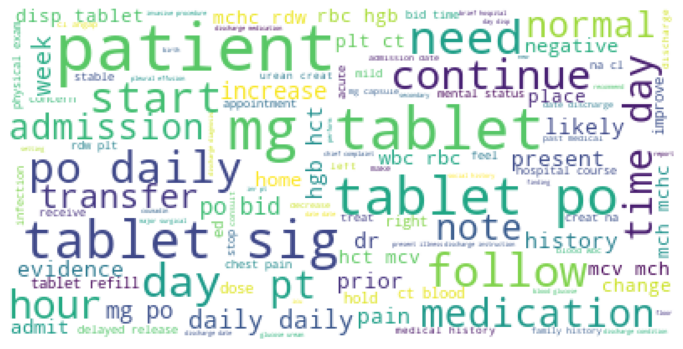

In [21]:
make_word_cloud(df['content_txt_preprocessed'], stop_words)

In [22]:
get_top_ngram(df['content_txt_preprocessed'], ngram=1, top_n=100, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [23]:
get_top_ngram(df['content_txt_preprocessed'], ngram=2, top_n=100, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [24]:
get_top_ngram(df['content_txt_preprocessed'], ngram=3, top_n=100, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



## 3.3 Build a LDA model and do grid search on learning rate and n_components
* In grid search the optimal component is 10. too few.

* But when forcing the components to be 20, performance is worse, most files fell into topic 0

* could work on adding more stop words. but for large text probably need to involve embedding.



In [54]:
txt_lda_output = do_vectorization_lda(df['content_txt_preprocessed'], n_components=10, stop_words=stop_words, max_features=10000)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



Sparsicity:  14.422002200220021 %


In [55]:
txt_lda_output

{'best_lda_model': LatentDirichletAllocation(batch_size=64, doc_topic_prior=None,
                           evaluate_every=-1, learning_decay=0.7,
                           learning_method='batch', learning_offset=10,
                           max_doc_update_iter=100, max_iter=10,
                           mean_change_tol=0.001, n_components=10, n_jobs=None,
                           perp_tol=0.1, random_state=None,
                           topic_word_prior=None, total_samples=1000000.0,
                           verbose=0),
 'data_vectorized': <303x3000 sparse matrix of type '<class 'numpy.int64'>'
 	with 131096 stored elements in Compressed Sparse Row format>,
 'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                 ngram_range=(1, 1), preprocessor=None,
                 stop_wor

In [56]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(txt_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5       -5.735119   33.248058       1        1  27.230120
8      -83.404358  -72.700508       2        1  17.864010
6      -42.916199   93.305588       3        1  16.632013
7      105.543915   18.418188       4        1  11.630346
3      -24.802519  -33.548363       5        1   8.609040
1       50.746506   80.059196       6        1   8.005535
4      -85.972198   16.905344       7        1   3.680579
9        6.318287 -101.061157       8        1   2.307158
2       42.627857  -16.544725       9        1   2.150462
0       85.251022  -74.120674      10        1   1.890739, topic_info=            Term         Freq        Total Category  logprob  loglift
1973     patient  2902.000000  2902.000000  Default  30.0000  30.0000
315        blood  2899.000000  2899.000000  Default  29.0000  29.0000
2679      tablet  4439.000000  4439.000000  Default  28.0000  28.0000
758    discharge  2670.000000  2670.000000  Default  27.0000  27.0000
651        daily  2685.000000  2685.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1070      follow    28.957541  1229.859870  Topic10  -5.1692   0.2194
1622  medication    28.968908  1370.477045  Topic10  -5.1688   0.1115
1480        left    27.447069  1067.665911  Topic10  -5.2228   0.3072
608       course    24.416990   718.357652  Topic10  -5.3398   0.5865
2352       right    24.412219  1628.840132  Topic10  -5.3400  -0.2323

[745 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
22        1  0.945712    acei
22        2  0.035026    acei
26        1  0.203778    acid
26        2  0.115474    acid
26        3  0.292082    acid
...     ...       ...     ...
2988     10  0.041010    year
2998      1  0.362809  zoster
2998      2  0.120936  zoster
2998      3  0.060468  zoster
2998      8  0.423278  zoster

[2712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 7, 8, 4, 2, 5, 10, 3, 1])

In [57]:
txt_lda_metrics = evalute_lda(txt_lda_output)
txt_lda_metrics['df_document_topic_top']

In [58]:
txt_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0          5             99
1          8             53
2          6             42
3          3             39
4          1             26
5          7             18
6          0             13
7          4              6
8          9              4
9          2              3

In [59]:
txt_lda_metrics['df_topic_keywords']

Word 0     Word 1     Word 2       Word 3      Word 4     Word 5  \
Topic 0    patient  discharge       unit         date      status        day   
Topic 1     tablet        sig      daily          day       right      leave   
Topic 2     mitral   lymphoma      daily        final       valve    patient   
Topic 3  discharge    patient    history   medication         day  admission   
Topic 4      place     tablet        sig         tube  aspiration      daily   
Topic 5     tablet      daily        day          sig     patient  discharge   
Topic 6      blood    patient  discharge     negative     culture        day   
Topic 7      right       left     normal  ventricular      aortic     tablet   
Topic 8     tablet        sig      blood          day       daily       time   
Topic 9      blood     biopsy      liver       marrow       right       cell   

            Word 6       Word 7      Word 8    Word 9      Word 10  \
Topic 0       post    admission     history   disease  examination   
Topic 1  discharge        blood      refill      disp         pain   
Topic 2    culture  respiratory      normal   leaflet  ventricular   
Topic 3       date         pain     present    status        right   
Topic 4    patient        acute        time  evidence    discharge   
Topic 5      blood      history  medication      time    admission   
Topic 6      right       normal         wbc   history    admission   
Topic 7      small        leave       valve  effusion         pain   
Topic 8  discharge         pain        need      hour      patient   
Topic 9     normal      patient       start     blast         bone   

               Word 11     Word 12     Word 13  Word 14    Word 15    Word 16  \
Topic 0       positive        care  hemorrhage     rate      blood   hospital   
Topic 1           time    incision      artery     left    history       date   
Topic 2  regurgitation   discharge        cell     left     aortic        prn   
Topic 3         lesion      follow        time  seizure       head   transfer   
Topic 4      pneumonia         day    continue  heparin       need      bleed   
Topic 5           pain      follow    continue     need       date       home   
Topic 6          start         neg        pain      plt       lung        low   
Topic 7        patient      artery    moderate     size       mild     mitral   
Topic 8        history  medication        date  capsule  admission     follow   
Topic 9     transplant       daily       acute    count   leukemia  discharge   

           Word 17   Word 18       Word 19  
Topic 0     remain      tube    medication  
Topic 1     follow   surgery          week  
Topic 2       gram     study        sputum  
Topic 3     normal  hospital          home  
Topic 4  placement      line         right  
Topic 5    present   capsule           inr  
Topic 6      urine       hct        tablet  
Topic 7   systolic      wall          note  
Topic 8   continue       wbc         fluid  
Topic 9      fever  negative  chemotherapy

In [60]:
txt_lda_metrics['df_topic_keywords_matrix']

aaa        abd    abdoman    abdomen   abdominal        abg  \
Topic0   5.606662   0.100010   5.562372   0.100036    0.103645   0.100049   
Topic1   0.126678   0.671078   9.523504   9.558509   21.296353   0.100032   
Topic2   0.100017   6.940499   2.351118   5.445393    8.039517   1.990745   
Topic3   6.503056  25.592049  12.228160   8.562275   43.828502   0.100041   
Topic4   0.100022  20.377047   6.773163  18.548119   28.596306   0.100057   
Topic5  17.783849  62.370765  28.651341  38.325059   87.597557  20.462621   
Topic6   1.016005  44.429313  16.516257  49.598163  114.109939  11.111482   
Topic7  12.789716  31.427680  47.318114  26.344885   80.109988   0.100027   
Topic8   0.100012  62.878822  22.418609  31.507161   80.697572  17.834939   
Topic9   0.873984   8.212737   0.657361   3.010400    1.620620   0.100006   

         ability   ablation       able   abnormal  ...     yellow  yesterday  \
Topic0  0.100040   0.100211   0.615201   0.122676  ...   0.100047   0.100002   
Topic1  6.396930   3.608949  27.129542   2.769160  ...   6.807668   1.866643   
Topic2  0.100000   0.100005   5.132493   0.100019  ...   0.100020   0.100011   
Topic3  0.100012   0.100004  29.845882  41.247105  ...   0.100034   7.186019   
Topic4  0.100051   0.100021   0.100022   4.996311  ...   0.100546   0.100010   
Topic5  2.848741  32.090726  31.893620  11.551037  ...  16.397928  26.726043   
Topic6  0.100110   0.100021  18.477015   5.697700  ...  10.476438   0.228683   
Topic7  0.100015   7.512535  14.223899  10.332823  ...   1.494481   6.685895   
Topic8  8.054057   0.100018  32.017337  25.877312  ...  16.084479   2.906684   
Topic9  0.100043   5.187510  10.564988   7.305856  ...   2.338360   0.100010   

           young        yrs    zantac     zofran   zolpidem      zone  \
Topic0  0.100013   0.100006  0.100077   0.100000   0.100011  0.100175   
Topic1  0.100009   0.133998  0.100008   0.100006   0.100015  1.153923   
Topic2  0.100005   0.100014  0.100001   0.100000   0.100007  0.100012   
Topic3  0.100022   6.062654  8.436273   2.586324   0.100017  0.100144   
Topic4  0.100029   0.100046  0.100021   0.100005   0.100022  0.100035   
Topic5  4.160050  12.040010  4.763562   6.934208   8.043654  2.599870   
Topic6  9.039845   2.114015  0.100005   0.970671  10.673030  9.121320   
Topic7  0.100011   5.364150  0.100014   1.603543   1.416074  2.524485   
Topic8  0.100018  10.885106  0.100037  15.032175   0.267163  0.100029   
Topic9  0.100000   0.100003  0.100002   1.473067   0.100008  0.100007   

          zoster      zosyn  
Topic0  0.100000   0.100009  
Topic1  0.100001   0.825876  
Topic2  0.100022   0.100019  
Topic3  0.100002   8.884893  
Topic4  0.100028  12.903433  
Topic5  5.927700  10.064405  
Topic6  0.685892  27.338872  
Topic7  0.100016   0.126904  
Topic8  2.334230  28.762923  
Topic9  7.452108   0.892666  

[10 rows x 3000 columns]

## 3.4 Make prediction

In [61]:
my_data = df.content_txt_preprocessed[2]
topic, prob_scores = predict_topic(my_data, txt_lda_output, txt_lda_metrics)
print(topic)

['tablet', 'daily', 'day', 'sig', 'patient', 'discharge', 'blood', 'history', 'medication', 'time', 'admission', 'pain', 'follow', 'continue', 'need', 'date', 'home', 'present', 'capsule', 'inr']


In [62]:
prob_scores

array([[6.72200115e-05, 6.72236250e-05, 6.72245916e-05, 6.72215075e-05,
        1.96276401e-01, 3.93661178e-01, 9.10994726e-02, 6.32097432e-02,
        2.55417096e-01, 6.72207115e-05]])

# 4. Conduct topic modeling using History of Present Illness
## 4.1 EDA (word cloud and ngrams)

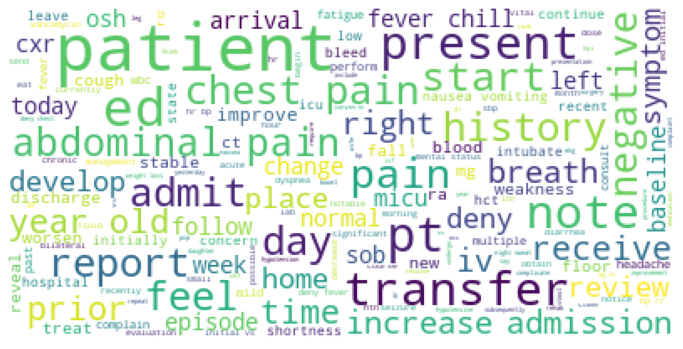

In [63]:
make_word_cloud(df['history_of_present_illness_preprocessed'], stop_words=stop_words)

In [65]:
get_top_ngram(df['history_of_present_illness_preprocessed'], ngram=1, top_n=100, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [66]:
get_top_ngram(df['history_of_present_illness_preprocessed'], ngram=2, top_n=100, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [67]:
get_top_ngram(df['history_of_present_illness_preprocessed'], ngram=3, top_n=100, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



## 4.2 LDA with grid search on history of present illness
* When using the optimal n_comopnents = 10
    * topics are very vague, probably should add more stop words
    * seems like to have very little predictibility
* try n_components = 20
    * still to many irrelevant words


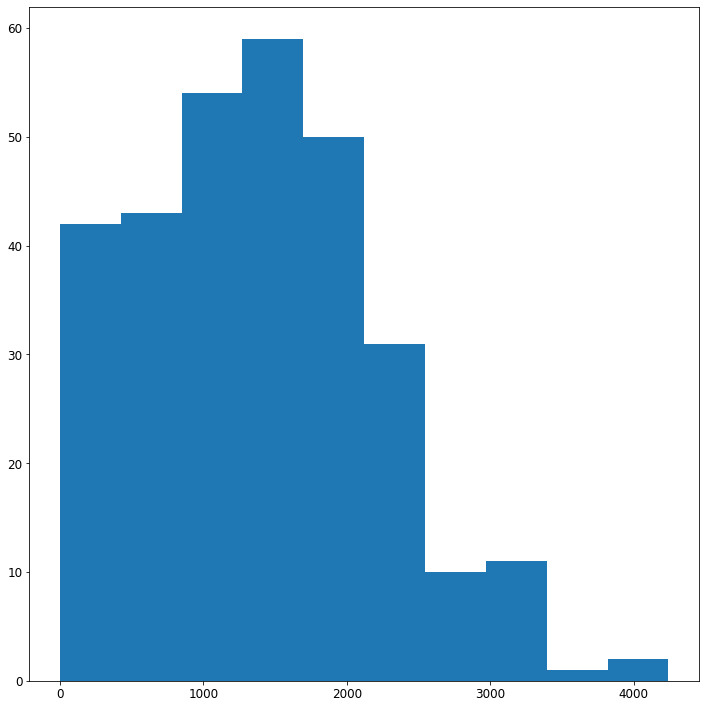

In [82]:
data = df['history_of_present_illness']
length_list = [len(x) for x in data]
plt.hist(length_list)
plt.show()

In [69]:

hopi_lda_output = do_vectorization_lda(df['history_of_present_illness_preprocessed'], n_components = 20, stop_words=stop_words, max_features=5000)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



Sparsicity:  2.5287128712871287 %


In [70]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(hopi_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14      10.171366  -53.540276       1        1  24.294141
8     -101.892860   42.937393       2        1  19.440434
2       85.928810  106.094154       3        1  13.177027
18     136.089218  -92.910179       4        1   8.857496
9       79.348701  -40.119984       5        1   5.434358
0       83.109245   35.448467       6        1   3.674850
3      213.473038   41.946079       7        1   3.616374
17     -31.048893   34.643204       8        1   2.611990
10      98.473747  177.305634       9        1   2.527500
16     201.941727  -43.744518      10        1   2.057066
7      -49.429008  114.274796      11        1   1.935507
11     -64.823723  -36.355507      12        1   1.912895
12      27.111805    8.780351      13        1   1.816003
6      143.976868   63.629215      14        1   1.790216
5       61.187332 -117.276947      15        1   1.686668
1      138.951813   -7.870273      16        1   1.667950
15      17.865295  157.992325      17        1   1.370824
19     172.425110  130.645905      18        1   0.791229
13     -24.868713 -115.985947      19        1   0.734950
4       22.694017   81.451035      20        1   0.602523, topic_info=           Term        Freq       Total Category  logprob  loglift
1798    patient  462.000000  462.000000  Default  30.0000  30.0000
1765       pain  505.000000  505.000000  Default  29.0000  29.0000
6     abdominal  149.000000  149.000000  Default  28.0000  28.0000
2690   transfer  196.000000  196.000000  Default  27.0000  27.0000
1909    present  206.000000  206.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1489        low    1.137387   84.335369  Topic20  -5.0330   0.8057
2268        say    0.931517   27.501198  Topic20  -5.2326   1.7266
2118     repeat    0.908651   28.362338  Topic20  -5.2575   1.6709
1110    gastric    0.824629   15.335363  Topic20  -5.3545   2.1888
1765       pain    1.228064  505.969440  Topic20  -4.9563  -0.9092

[1399 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2         1  0.391517    abd
2         2  0.261011    abd
2         3  0.032626    abd
2         6  0.032626    abd
2         8  0.228385    abd
...     ...       ...    ...
2999      4  0.085563  zosyn
2999      7  0.042781  zosyn
2999      9  0.042781  zosyn
2999     11  0.042781  zosyn
2999     16  0.042781  zosyn

[3957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 9, 3, 19, 10, 1, 4, 18, 11, 17, 8, 12, 13, 7, 6, 2, 16, 20, 14, 5])

In [71]:
hopi_lda_metrics = evalute_lda(hopi_lda_output)
hopi_lda_metrics['df_document_topic_top']

In [72]:
hopi_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0          14             65
1           8             47
2           0             35
3           2             35
4          18             20
5           3             13
6           9             12
7          10             10
8           7             10
9          11              8
10         17              8
11         16              6
12          1              6
13         12              5
14         15              5
15          6              5
16          5              4
17         19              4
18          4              3
19         13              2

In [76]:
hopi_lda_metrics['df_topic_keywords']

Word 0       Word 1        Word 2      Word 3        Word 4  \
Topic 0       pain          day     abdominal        past          note   
Topic 1      fever    discharge       present    negative         shunt   
Topic 2    patient         pain         chest        note          deny   
Topic 3    patient         pain       history        home         admit   
Topic 4       mass    abdominal         blood  distension         great   
Topic 5      trach      present  pancreatitis        pain         fluid   
Topic 6    patient         home       receive    transfer         floor   
Topic 7   transfer         ercp         start        deny       require   
Topic 8       pain         deny         fever       chest     abdominal   
Topic 9    patient         note         start         low       present   
Topic 10   seizure     transfer       patient       admit      continue   
Topic 11      pain       aortic         chest         old          year   
Topic 12   patient  bradycardia         right     present        report   
Topic 13    emesis       ground           osh      coffee         prior   
Topic 14   patient         pain          deny         day         start   
Topic 15      pain         note         begin     patient          week   
Topic 16   patient         note        ativan     present       history   
Topic 17      pain     headache           abd        deny          note   
Topic 18      pain       report          week        year         chest   
Topic 19   stridor         year      transfer         ent  tracheostomy   

             Word 5     Word 6     Word 7      Word 8    Word 9  \
Topic 0    transfer    patient    present       admit      time   
Topic 1     develop        day    patient       fluid   culture   
Topic 2       right    history    receive      breath  transfer   
Topic 3    weakness       week        pna         wbc      copd   
Topic 4     stomach    present       year        unit      pain   
Topic 5       level     normal      ovary      lumbar       low   
Topic 6   discharge  admission      place         cxr  negative   
Topic 7       floor    present     stable  transplant       icu   
Topic 8        note    patient     review       chill   present   
Topic 9       right       time      fever     seizure  headache   
Topic 10       micu      start    develop        left      year   
Topic 11    present      graft     reveal    stenosis  coronary   
Topic 12       left   vomiting       year       admit  atropine   
Topic 13    medical    perform       time    transfer    stable   
Topic 14     report    present   transfer        feel     fever   
Topic 15   increase    history       year        male    breath   
Topic 16     status        osh       year    intubate      home   
Topic 17       feel      bleed  admission     receive     today   
Topic 18   headache       deny       feel    transfer    change   
Topic 19   tracheal       tube        old   admission      post   

                  Word 10     Word 11       Word 12         Word 13  \
Topic 0              week        micu       receive           prior   
Topic 1              rash     history         leave             ago   
Topic 2            nausea       prior     shortness           cough   
Topic 3         discharge        male          note        hospital   
Topic 4               old        scan   significant     demonstrate   
Topic 5               alt         ast          note            etoh   
Topic 6             admit       fever  intermittent        drainage   
Topic 7           disease        year      positive        hospital   
Topic 8            change      nausea           day           cough   
Topic 9            report   extremity           min         receive   
Topic 10              old      report      dilantin          ativan   
Topic 11  catheterization       bring       disease          repair   
Topic 12          carotid  difficulty          pain          nausea   
Topic 13         recently    hospi

In [77]:
hopi_lda_metrics['df_topic_keywords_matrix']

aaa  abcesse        abd  abdom  abdoman   abdomen  abdominal  \
Topic0   0.0500     0.05   1.190371   0.05     1.05  1.050000  11.597627   
Topic1   0.0500     0.05   0.050000   0.05     0.05  1.050000   0.050000   
Topic2   0.0500     0.05   1.333127   1.05     0.05  1.953033  16.023120   
Topic3   0.0500     0.05   0.050000   0.05     0.05  1.050000   3.241413   
Topic4   0.0500     0.05   0.050000   0.05     0.05  0.050000   4.881502   
Topic5   0.0500     1.05   0.050000   0.05     2.05  1.050000   1.144040   
Topic6   0.0500     0.05   0.050000   0.05     1.05  0.050000   3.732971   
Topic7   0.0500     0.05   0.050000   0.05     0.05  1.050000   0.050000   
Topic8   1.2027     0.05   8.105258   0.05     4.05  5.050000  56.128208   
Topic9   3.0500     0.05   0.050000   0.05     0.05  0.050000   0.948974   
Topic10  0.0500     0.05   0.050000   0.05     0.05  0.050000   0.050000   
Topic11  0.0500     0.05   0.050000   0.05     1.05  0.050000   1.110870   
Topic12  0.0500     0.05   1.050000   0.05     1.05  0.050000   1.050000   
Topic13  0.0500     0.05   0.050000   0.05     0.05  0.050000   1.050794   
Topic14  5.8973     0.05  12.571244   0.05     0.05  2.146967  39.084260   
Topic15  0.0500     0.05   0.050000   0.05     2.05  1.050000   0.050000   
Topic16  0.0500     0.05   0.050000   0.05     0.05  0.050000   2.996598   
Topic17  0.0500     0.05   8.050000   0.05     0.05  0.050000   4.028688   
Topic18  1.0500     1.05   0.050000   0.05     0.05  0.050000  12.730935   
Topic19  0.0500     0.05   0.050000   0.05     0.05  0.050000   0.050000   

         abdominopelvic  abduction       abg  ...  yetserday  yield   yom  \
Topic0             0.05       0.05  3.050000  ...       0.05   0.05  0.05   
Topic1             0.05       1.05  0.050000  ...       0.05   0.05  0.05   
Topic2             0.05       0.05  3.264892  ...       0.05   0.05  0.05   
Topic3             0.05       0.05  3.338261  ...       0.05   0.05  0.05   
Topic4             0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic5             1.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic6             0.05       0.05  0.050000  ...       0.05   1.05  0.05   
Topic7             0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic8             0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic9             0.05       0.05  2.050000  ...       0.05   0.05  0.05   
Topic10            0.05       0.05  1.050000  ...       0.05   0.05  0.05   
Topic11            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic12            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic13            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic14            0.05       0.05  5.546846  ...       0.05   0.05  1.05   
Topic15            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic16            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic17            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic18            0.05       0.05  0.050000  ...       1.05   0.05  1.05   
Topic19            0.05       0.05  0.050000  ...       0.05   0.05  0.05   

          yrs  zantac  zero    zofran  zometa  zoster      zosyn  
Topic0   0.05    0.05  0.05  1.155928    0.05    0.05   0.050000  
Topic1   0.05    0.05  0.05  0.050000    0.05    0.05   0.899934  
Topic2   0.05    0.05  1.05  2.808251    0.05    0.05   0.050000  
Topic3   0.05    1.05  0.05  0.050000    0.05    0.05   0.921475  
Topic4   0.05    0.05  0.05  0.050000    0.05    0.05   0.050000  
Topic5   0.05    0.05  0.05  0.050000    0.05    0.05   0.050000  
Topic6   0.05    0.05  0.05  0.050000    0.05    0.05   0.050000  
Topic7   0.05    0.05  0.05  1.050000    0.05    1.05   1.183575  
Topic8   0.05    0.05  0.05  1.439857    0.05    0.05   2.327089  
Topic9   0.05    0.05  0.05  0.795963    0.05    0.05   0.050000  
Topic10  0.05    0.05  0.05  0.050000    0.05    0.05   1.16

## 4.3 Make predictions

In [78]:
my_data = df['history_of_present_illness'][0]
topic, prob_scores = predict_topic(my_data, hopi_lda_output, hopi_lda_metrics)
print(my_data)
print(topic)

history of present illness:,,mr. [**known lastname 3234**] is a 36 year old gentleman with a pmh signifciant,,with dilated cardiomyopathy s/p aicd, asthma, and htn admitted,,to an osh with dyspnea now admitted to the micu after pea arrest,,x2. the patient initially presented to lgh ed with hypoxemic,,respiratory distress. while at the osh, he received ctx,,,azithromycin, sc epinephrine, and solumedrol. while at the osh,,,he became confused and subsequently had an episode of pea arrest,,and was intubated. he received epinephrine, atropine, magnesium,,,and bicarb. in addition, he had bilateral needle thoracostomies,,with report of air return on the left, and he subsequently had,,bilateral chest tubes placed.  after approximately 15-20 minutes,,of rescucitation, he had rosc. he received vecuronium and was,,started on an epi gtt for asthma and a cooling protocol, and was,,then transferred to [**hospital1 18**] for further evaluation. of note, the,,patient was admitted to lgh in [**1-4**] f

In [79]:
prob_scores

array([[4.54545468e-04, 4.54545457e-04, 1.95738995e-02, 4.54545460e-04,
        4.54545455e-04, 4.54545458e-04, 4.54545459e-04, 4.54545459e-04,
        4.54545459e-04, 4.54545460e-04, 9.72244282e-01, 4.54545469e-04,
        4.54545460e-04, 4.54545457e-04, 4.54545463e-04, 4.54545458e-04,
        4.54545470e-04, 4.54545459e-04, 4.54545463e-04, 4.54545458e-04]])

# 5 Topic modeling on discharge diagnosis
# 5.1 EDA (word cloud and ngrams)

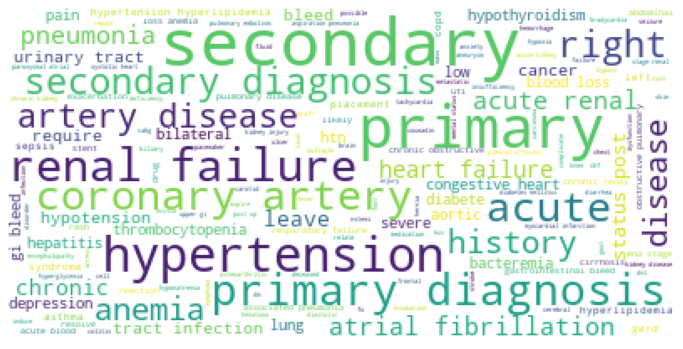

In [83]:
make_word_cloud(df['discharge_diagnosis_preprocessed'], stop_words=stop_words)

In [84]:
get_top_ngram(df['discharge_diagnosis_preprocessed'], ngram=1, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [85]:
get_top_ngram(df['discharge_diagnosis_preprocessed'], ngram=2, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [86]:
get_top_ngram(df['discharge_diagnosis_preprocessed'], ngram=3, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



## 5.2 LDA with grid search with discharge diagnosis 
* the topics are pretty explicit, but there are still many overlaps between topics. 
* need more n_components even though mathematically it would not be ideal, would match the reality better

Topic 0: (gastrointestinal disease,pneumonia, asthma)	primary	associated	bleed	gastrointestinal	pneumonia	pulmonary	hypertension	lung	lymphoma	care	asthma	ventricular	exacerbation	cell	gastric	likely	psychosis	nonsmall	gerd	upper

Topic 1: (brain injury, kidney issues)	right	frontal	bleed	brain	injury	acute	kidney	retroperitoneal	supratherapeutic	anemia	inr	primary	carcinoma	secondary	deficiency	narcotic	fluid	induce	respiratory	failureacute

Topic 2: (renal disease)	renal	acute	failure	require	primary	chronic	syndrome	stent	reflux	cell	pneumonia	mental	status	loss	tract	blood	placement	carcinoma	complicate	htn

Topic 3: (metastatic cancel)	secondary	cell	metastatic	small	primary	cancer	bowel	hyperlipidemia	setting	induce	acute	atrial	reaction	lung	respiratory	bradycardia	post	status	renal	coronary

Topic 4: (anemia, renal)	secondary	blood	acute	low	anemia	renal	bleed	operative	common	right	leave	require	hematoma	ivc	disorder	history	dvt	chronic	likely	kidney

Topic 5: (heart disease, liver)	heart	disease	failure	renal	stage	congestive	liver	artery	secondary	atrial	chronic	end	coronary	transplant	placement	right	relate	pacemaker	post	status

Topic 6: (kidney)	chronic	kidney	bacteremia	fibrillation	bilateral	abscess	type	septic	diabete	diastolic	ulcer	fluid	acquire	leave	drug	mellitus	knee	bleed	pulmonary	acute

Topic 7: (artery issues)	artery	coronary	aortic	graft	disease	bypass	right	cabg	carotid	aneurysm	pain	vein	leave	require	effusion	shock	stenosis	history	prostatic	chest

Topic 8: (chronic disease)	primary	blood	loss	disease	diagnosis	obstructive	chronic	elevation	artery	myocardial	pulmonary	hernia	severe	sepsis	ulcer	mellitus	acute	respiratory	hypertensive	status

Topic 9: (hemorrgage)	primary	tract	hemorrhage	urinary	leave	infection	expire	deceased	multiple	status	atrial	mca	intraparenchymal	artery	mental	cord	renal	fibrillation	cerebral	ventricular

In [91]:
dd_lda_output = do_vectorization_lda(df['discharge_diagnosis_preprocessed'], n_components=20, stop_words=stop_words, max_features=1000)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



Sparsicity:  1.028607380047783 %


In [92]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(dd_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
13     -85.548729  219.314896       1        1  12.979577
9     -237.387283  208.774475       2        1  11.802537
7     -166.352722  100.821022       3        1  10.028761
3      218.784805   -1.803937       4        1   6.704527
17      36.281414  144.953735       5        1   6.489506
0       93.540573 -257.221924       6        1   6.413934
5      -69.249237 -288.373444       7        1   5.071942
15     210.104385 -153.689728       8        1   4.794242
18    -160.060181  -22.069309       9        1   4.395489
6     -217.419159 -236.945999      10        1   4.352402
8     -296.664124   46.149372      11        1   3.946310
2      -52.677769   66.441452      12        1   3.365846
14      80.857002   29.013821      13        1   3.243070
1       59.780125  272.171051      14        1   3.236499
10     -30.286112  -47.448093      15        1   3.108147
11      94.040932  -91.272835      16        1   3.002188
19      -5.339833 -168.747726      17        1   2.849578
16     178.020981  139.673370      18        1   1.879914
4     -127.722473 -139.895355      19        1   1.845073
12    -277.188538  -98.279022      20        1   0.490459, topic_info=              Term       Freq      Total Category  logprob  loglift
427        failure  65.000000  65.000000  Default  30.0000  30.0000
304      diagnosis  57.000000  57.000000  Default  29.0000  29.0000
15           acute  62.000000  62.000000  Default  28.0000  28.0000
1006     secondary  95.000000  95.000000  Default  27.0000  27.0000
501          heart  23.000000  23.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
397    eschirichia   0.013973   1.487987  Topic20  -7.2703   0.6495
412          exlap   0.013973   1.402530  Topic20  -7.2703   0.7087
380    enlargement   0.013973   1.426086  Topic20  -7.2703   0.6920
381   enterobacter   0.013973   2.359422  Topic20  -7.2703   0.1885
382   enterococcus   0.013973   1.525978  Topic20  -7.2703   0.6243

[1193 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1        13  0.715478     abcess
2         2  0.291359  abdominal
2         4  0.145679  abdominal
2         6  0.145679  abdominal
2        12  0.145679  abdominal
...     ...       ...        ...
1213     14  0.308238      wound
1213     15  0.308238      wound
1214      2  0.279095       year
1214      4  0.279095       year
1214     18  0.279095       year

[1800 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 8, 4, 18, 1, 6, 16, 19, 7, 9, 3, 15, 2, 11, 12, 20, 17, 5, 13])

In [93]:
dd_lda_metrics = evalute_lda(dd_lda_output)
dd_lda_metrics['df_document_topic_top']

In [94]:
dd_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0           0             44
1          13             34
2           9             29
3           3             17
4           8             16
5           6             16
6          18             15
7           1             14
8          14             13
9          17             13
10          7             13
11          5             13
12          4             10
13         15             10
14          2              9
15         19              9
16         10              9
17         11              9
18         12              5
19         16              5

In [95]:
dd_lda_metrics['df_topic_keywords']

Word 0     Word 1      Word 2       Word 3          Word 4  \
Topic 0        failure      acute       heart        renal         chronic   
Topic 1        failure      renal         non       sepsis           small   
Topic 2         artery     aortic        left  obstruction          bypass   
Topic 3      secondary    disease     primary          end            post   
Topic 4   hypertension        hcv         hcc     diabetes       hepatitis   
Topic 5      secondary  pneumonia     primary         mssa  hypothyroidism   
Topic 6          right     expire       bleed       status         disease   
Topic 7         status       post       renal        acute         failure   
Topic 8      secondary    primary   diagnosis     deceased         disease   
Topic 9        disease   coronary      artery      chronic         primary   
Topic 10       require       mass       shock        renal            post   
Topic 11     secondary  diagnosis     primary        bleed         disease   
Topic 12       hypoxia   reaction        ercp        wound        elective   
Topic 13       primary  diagnosis   secondary        acute         failure   
Topic 14     diagnosis  secondary     primary       asthma    exacerbation   
Topic 15          cell      blood   carcinoma       cancer             low   
Topic 16    hemorrhage  pneumonia       leave   idiopathic            year   
Topic 17       history     anemia       acute        right           leave   
Topic 18         blood      acute      anemia        right            loss   
Topic 19     secondary    primary  depression   transplant           liver   

                        Word 5        Word 6            Word 7         Word 8  \
Topic 0             congestive     diastolic         pneumonia       systolic   
Topic 1                   copd   respiratory        complicate      abdominal   
Topic 2                  graft      coronary      hypertension         common   
Topic 3                  stage         renal          coronary   hypertension   
Topic 4                  bleed        aortic         cirrhosis  postoperative   
Topic 5                 atrial        anemia        bacteremia       possible   
Topic 6                 induce     pneumonia           primary          leave   
Topic 7              secondary     pneumonia         infection           loss   
Topic 8                history  hypertension       hypotension   fibrillation   
Topic 9              pulmonary  hypertension         diagnosis      secondary   
Topic 10               failure        septic         pulmonary          stage   
Topic 11                  vein    complicate             trach      alcoholic   
Topic 12              sedation      dilantin  hypersensitivity           stab   
Topic 13                atrial         renal         pneumonia      infection   
Topic 14  hypercholesterolemia       diabete           disease       toxicity   
Topic 15               primary          lung         secondary     metastatic   
Topic 16                   ago   neutropenia      pericarditis            rib   
Topic 17                  left       disease           primary         injury   
Topic 18             secondary         bleed             upper           pain   
Topic 19               urinary     infection           hepatic          tract   

                Word 9         Word 10         Word 11           Word 12  \
Topic 0     associated       secondary          injury      pancreatitis   
Topic 1        primary            post           acute      hypertension   
Topic 2        carotid         disease           leave            atrial   
Topic 3          bleed          artery           stent        myocardial   
Topic 4            htn          asthma      angioedema          effusion   
Topic 5          think      aspiration             chf  thrombocytopenia   
Topic 6   hypertension           ulcer           upper             nsaid   
Topic 7          blood       placement         primary            a

In [96]:
hopi_lda_metrics['df_topic_keywords_matrix']

aaa  abcesse        abd  abdom  abdoman   abdomen  abdominal  \
Topic0   0.0500     0.05   1.190371   0.05     1.05  1.050000  11.597627   
Topic1   0.0500     0.05   0.050000   0.05     0.05  1.050000   0.050000   
Topic2   0.0500     0.05   1.333127   1.05     0.05  1.953033  16.023120   
Topic3   0.0500     0.05   0.050000   0.05     0.05  1.050000   3.241413   
Topic4   0.0500     0.05   0.050000   0.05     0.05  0.050000   4.881502   
Topic5   0.0500     1.05   0.050000   0.05     2.05  1.050000   1.144040   
Topic6   0.0500     0.05   0.050000   0.05     1.05  0.050000   3.732971   
Topic7   0.0500     0.05   0.050000   0.05     0.05  1.050000   0.050000   
Topic8   1.2027     0.05   8.105258   0.05     4.05  5.050000  56.128208   
Topic9   3.0500     0.05   0.050000   0.05     0.05  0.050000   0.948974   
Topic10  0.0500     0.05   0.050000   0.05     0.05  0.050000   0.050000   
Topic11  0.0500     0.05   0.050000   0.05     1.05  0.050000   1.110870   
Topic12  0.0500     0.05   1.050000   0.05     1.05  0.050000   1.050000   
Topic13  0.0500     0.05   0.050000   0.05     0.05  0.050000   1.050794   
Topic14  5.8973     0.05  12.571244   0.05     0.05  2.146967  39.084260   
Topic15  0.0500     0.05   0.050000   0.05     2.05  1.050000   0.050000   
Topic16  0.0500     0.05   0.050000   0.05     0.05  0.050000   2.996598   
Topic17  0.0500     0.05   8.050000   0.05     0.05  0.050000   4.028688   
Topic18  1.0500     1.05   0.050000   0.05     0.05  0.050000  12.730935   
Topic19  0.0500     0.05   0.050000   0.05     0.05  0.050000   0.050000   

         abdominopelvic  abduction       abg  ...  yetserday  yield   yom  \
Topic0             0.05       0.05  3.050000  ...       0.05   0.05  0.05   
Topic1             0.05       1.05  0.050000  ...       0.05   0.05  0.05   
Topic2             0.05       0.05  3.264892  ...       0.05   0.05  0.05   
Topic3             0.05       0.05  3.338261  ...       0.05   0.05  0.05   
Topic4             0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic5             1.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic6             0.05       0.05  0.050000  ...       0.05   1.05  0.05   
Topic7             0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic8             0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic9             0.05       0.05  2.050000  ...       0.05   0.05  0.05   
Topic10            0.05       0.05  1.050000  ...       0.05   0.05  0.05   
Topic11            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic12            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic13            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic14            0.05       0.05  5.546846  ...       0.05   0.05  1.05   
Topic15            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic16            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic17            0.05       0.05  0.050000  ...       0.05   0.05  0.05   
Topic18            0.05       0.05  0.050000  ...       1.05   0.05  1.05   
Topic19            0.05       0.05  0.050000  ...       0.05   0.05  0.05   

          yrs  zantac  zero    zofran  zometa  zoster      zosyn  
Topic0   0.05    0.05  0.05  1.155928    0.05    0.05   0.050000  
Topic1   0.05    0.05  0.05  0.050000    0.05    0.05   0.899934  
Topic2   0.05    0.05  1.05  2.808251    0.05    0.05   0.050000  
Topic3   0.05    1.05  0.05  0.050000    0.05    0.05   0.921475  
Topic4   0.05    0.05  0.05  0.050000    0.05    0.05   0.050000  
Topic5   0.05    0.05  0.05  0.050000    0.05    0.05   0.050000  
Topic6   0.05    0.05  0.05  0.050000    0.05    0.05   0.050000  
Topic7   0.05    0.05  0.05  1.050000    0.05    1.05   1.183575  
Topic8   0.05    0.05  0.05  1.439857    0.05    0.05   2.327089  
Topic9   0.05    0.05  0.05  0.795963    0.05    0.05   0.050000  
Topic10  0.05    0.05  0.05  0.050000    0.05    0.05   1.16

## 5.3 Make predictions

In [99]:
my_data = df['discharge_diagnosis'][0]
topic, prob_scores = predict_topic(my_data, dd_lda_output, dd_lda_metrics)
print(my_data)
print(topic)

discharge diagnosis:,,anoxic brain injury s/p pea arrest x2,,status asthmaticus,,ventilator associated pneumonia,,chronic systolic heart failure,,l1 compression fracture,,seizures after hypoxic brain injury,,
['failure', 'acute', 'heart', 'renal', 'chronic', 'congestive', 'diastolic', 'pneumonia', 'systolic', 'associated', 'secondary', 'injury', 'pancreatitis', 'hypertension', 'brain', 'health', 'care', 'arrest', 'ventilator', 'bleed']


In [98]:
prob_scores

array([[0.91130346, 0.00227273, 0.00227273, 0.00227273, 0.00227273,
        0.00227273, 0.00227273, 0.00227273, 0.00227273, 0.00227273,
        0.00227273, 0.00227273, 0.00227273, 0.00227273, 0.04778745,
        0.00227273, 0.00227273, 0.00227273, 0.00227273, 0.00227273]])

# 6 Topic Modeling using chief complaint
## 6.1 EDA (word cloud and ngrams)

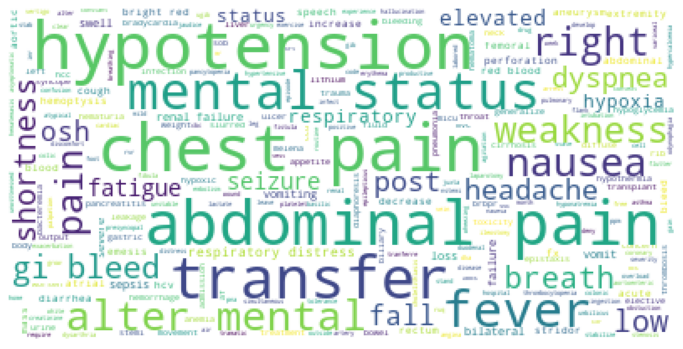

In [100]:
make_word_cloud(df['chief_complaint_preprocessed'], stop_words=stop_words)

In [101]:
get_top_ngram(df['chief_complaint_preprocessed'], ngram=1, top_n=20, stop_words=stop_words())

TypeError: 'frozenset' object is not callable

In [102]:
get_top_ngram(df['chief_complaint_preprocessed'], ngram=2, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [103]:
get_top_ngram(df['chief_complaint_preprocessed'], ngram=3, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



## 6.2 LDA with grid search by chief complaint
* Observation: the topics are not very well separated, quite a few overlapping topics
* Topics do not provide the underlying conditions either

Topic 0: (infection) fever headache sob cough	transfer	fever	headache	osh	sob	cough	fatigue	failure	sepsis	seizure	status	abdominal	respiratory	mental	pain	bleed	hypotension	altered	hypoxia	increase

Topic 1: (abdominal/renal disease)	failure	loss	renal	acute	aneurysm	blood	admission	abdominal	aortic	sob	nausea	dyspnea	low	alter	mental	status	fever	hypoxia	increase	seizure

Topic 2: (heart disease)	nausea	fatigue	elevated	swell	sepsis	vomiting	severe	aortic	fever	abdominal	hypotension	transfer	admission	loss	pain	hypoxia	sob	increase	seizure	fall

Topic 3: (seizure) chest	pain	seizure	increase	distress	fall	hypotension	headache	speech	right	status	respiratory	abdominal	breath	shortness	weakness	fever	hypoxia	sob	bilateral

Topic 4: ()	dyspnea	stridor	diarrhea	cough	fever	abdominal	renal	pain	failure	breath	shortness	hypoxia	sob	increase	seizure	fall	headache	hypotension	bilateral	swell

Topic 5: (abdominal disease)	pain	abdominal	right	fever	vomiting	weakness	nausea	alter	chest	cough	fall	osh	low	diarrhea	transfer	mental	status	hypoxia	sob	increase

Topic 6: (respiratory disease)	bleed	breath	shortness	increase	cough	osh	low	distress	respiratory	fever	hypoxia	sob	seizure	pain	fall	headache	hypotension	bilateral	swell	failure

Topic 7: (respiratory diease)	respiratory	weakness	distress	speech	bilateral	failure	increase	bleed	osh	extremity	pain	transfer	chest	hypotension	low	abdominal	fever	hypoxia	sob	seizure

Topic 8: (fall incidents)	hypotension	low	fall	extremity	severe	fever	bilateral	increase	blood	right	sepsis	status	weakness	pain	transfer	elevated	bleed	chest	hypoxia	sob

Topic 9: (mental state altered)	status	mental	altered	hypoxia	alter	red	rectum	bright	blood	admission	acute	transfer	seizure	abdominal	pain	hypotension	fever	sob	increase	fall

In [104]:
cc_lda_output = do_vectorization_lda(df['chief_complaint_preprocessed'], n_components=20, stop_words=stop_words, max_features=2000)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



Sparsicity:  0.6731625543506732 %


In [105]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(cc_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
19     189.476715   90.559631       1        1  10.217520
17     122.021187   52.053902       2        1   6.512923
14     176.226700  -96.572388       3        1   6.406327
15    -125.621895  -37.905827       4        1   6.255290
2     -118.096100   69.433083       5        1   5.520354
8        8.176218 -140.048309       6        1   5.389689
18      42.756020  -65.344604       7        1   5.201425
4      117.240044  -46.135876       8        1   5.119276
6      -28.998003  -57.103081       9        1   5.113810
5      -65.479088   10.937037      10        1   4.519159
1       92.198708 -132.921371      11        1   4.515535
11     110.389450  140.478760      12        1   4.475401
10     -23.974524   78.375420      13        1   4.310831
12       5.487069   10.056112      14        1   4.263846
7      187.299011   -2.644220      15        1   4.177525
3       25.882065  159.508102      16        1   3.993487
13     -62.501965  145.766479      17        1   3.882234
16     -76.996857 -117.115845      18        1   3.521884
9       50.043621   80.409058      19        1   3.433764
0       70.743263    5.535998      20        1   3.169720, topic_info=             Term       Freq      Total Category  logprob  loglift
255          pain  29.000000  29.000000  Default  30.0000  30.0000
318        status  13.000000  13.000000  Default  29.0000  29.0000
226        mental   9.000000   9.000000  Default  28.0000  28.0000
13          alter   9.000000   9.000000  Default  27.0000  27.0000
58          chest  12.000000  12.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
134       fatigue   0.031942   4.618721  Topic20  -6.6567  -1.5224
133          fall   0.031942   4.662353  Topic20  -6.6567  -1.5318
120     epistaxis   0.031942   2.080014  Topic20  -6.6567  -0.7247
130           eye   0.031942   1.375185  Topic20  -6.6567  -0.3109
125  exacerbation   0.031942   1.375185  Topic20  -6.6567  -0.3109

[836 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.830244  abdominal
0         4  0.075477  abdominal
0         5  0.075477  abdominal
1         2  0.719143   ablation
2         2  0.719143   abnormal
...     ...       ...        ...
374      10  0.747134       work
375       6  0.492236     worsen
375      18  0.492236     worsen
376       8  0.764272      wound
377       2  0.719143       year

[501 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 18, 15, 16, 3, 9, 19, 5, 7, 6, 2, 12, 11, 13, 8, 4, 14, 17, 10, 1])

In [106]:
cc_lda_metrics = evalute_lda(cc_lda_output)
cc_lda_metrics['df_document_topic_top']

In [107]:
cc_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0           0             39
1          19             32
2           4             21
3          17             18
4           6             18
5           7             17
6          14             17
7           2             17
8           1             15
9          15             14
10         12             13
11          3             12
12          8             12
13          5             11
14          9             11
15         13              9
16         18              8
17         11              7
18         16              6
19         10              6

In [108]:
cc_lda_metrics['df_topic_keywords']

Word 0       Word 1        Word 2       Word 3       Word 4  \
Topic 0      aneurysm    cirrhosis      elective    admission        stent   
Topic 1      headache      seizure         vomit     weakness       nausea   
Topic 2         bleed          low        aortic     decrease        urine   
Topic 3         swell      stridor           hcv          hcc       throat   
Topic 4         fever  hypotension    bacteremia          sob        cough   
Topic 5         blood          red        rectum       bright         pain   
Topic 6   respiratory      failure      distress      fatigue        renal   
Topic 7       dyspnea  bradycardia  hypoglycemia  hypotension        fluid   
Topic 8         right   hemoptysis           rib          mvc    epistaxis   
Topic 9      diarrhea         fall      transfer     elevated          low   
Topic 10     transfer          osh       hypoxic         micu      fatigue   
Topic 11      femoral          low          mass  hypotension       severe   
Topic 12    shortness       breath      vomiting       nausea   productive   
Topic 13      hypoxia          low      elevated        stemi       nausea   
Topic 14       status       mental         alter   intubation      require   
Topic 15     weakness       emesis        nausea      diffuse     appetite   
Topic 16    treatment     transfer           low  hypothermia       severe   
Topic 17  hypotension         post        status       sepsis       atrial   
Topic 18        acute    bilateral          loss        blood     bleeding   
Topic 19         pain        chest     abdominal       nausea  hypotension   

               Word 5        Word 6     Word 7        Word 8      Word 9  \
Topic 0        assist          coil      acomm           hep   secondary   
Topic 1       syncope   diaphoresis   increase    generalize      speech   
Topic 2        output        melena   aneurysm     abdominal    hematoma   
Topic 3          neck         liver   weakness      elevated   infection   
Topic 4          mssa      empyemas       port     induction  anesthesia   
Topic 5    transplant         right      admit          work      direct   
Topic 6      toxicity       lithium      bleed          left   pneumonia   
Topic 7      overload       colonic  ileostomy      obstruct      kidney   
Topic 8          pain          fall   movement        trauma      speech   
Topic 9    thrombosis     hematuria     recent     inability        dvts   
Topic 10          ccu           pna        rvr          week     develop   
Topic 11      concern       biliary  extremity          post      bypass   
Topic 12      urgency  hypertensive   wheezing  unwittnessed       cough   
Topic 13     atypical         white        cbc          cell    platelet   
Topic 14  cardiogenic           chf   critical         shock      lesion   
Topic 15         body         brbpr     sepsis          loss    transfer   
Topic 16          osh     extremity        ams  superimposed  cellulitis   
Topic 17  perforation        weight      ulcer       gastric        year   
Topic 18       anemia  oophorectomy      solid       ovarian     present   
Topic 19      lactate          code    radiate         black   vomitting   

             Word 10       Word 11        Word 12       Word 13  \
Topic 0         esld         tooth     extraction     pulmonary   
Topic 1      slurred     frequency      urination  dysgerminoma   
Topic 2   hematocrit         thigh       coronary       disease   
Topic 3       facial         sided           foot         leave   
Topic 4       follow          stab          wound           lft   
Topic 5      adrenal         tumor            leg      erythema   
Topic 6      temporo      parietal          large  pancytopenia   
Topic 7        stone         edema       intubate           svc   
Topic 8   hemorrhage        worsen        splenic           arm   
Topic 9         walk          vein        basilic      variceal   
Topic 10   stabilize       context  intrac

In [109]:
cc_lda_metrics['df_topic_keywords_matrix']

abdominal  ablation  abnormal  achyness  acomm  acute  admission  \
Topic0        0.05      0.05      0.05      0.05   1.05   0.05       1.05   
Topic1        0.05      0.05      0.05      1.05   0.05   0.05       0.05   
Topic2        2.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic3        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic4        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic5        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic6        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic7        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic8        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic9        0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic10       0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic11       0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic12       0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic13       0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic14       0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic15       1.05      0.05      0.05      0.05   0.05   0.05       1.05   
Topic16       0.05      0.05      0.05      0.05   0.05   0.05       0.05   
Topic17       0.05      1.05      1.05      0.05   0.05   0.05       0.05   
Topic18       0.05      0.05      0.05      0.05   0.05   3.05       0.05   
Topic19      15.05      0.05      0.05      0.05   0.05   0.05       0.05   

         admit  adrenal  agitation  ...   wbc  weakness  week  weight  \
Topic0    0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic1    0.05     0.05       1.05  ...  0.05      2.05  0.05    0.05   
Topic2    0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic3    0.05     0.05       0.05  ...  0.05      1.05  0.05    0.05   
Topic4    0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic5    1.05     1.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic6    0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic7    0.05     0.05       0.05  ...  0.05      1.05  0.05    0.05   
Topic8    0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic9    0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic10   0.05     0.05       0.05  ...  0.05      0.05  1.05    0.05   
Topic11   0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic12   0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic13   0.05     0.05       0.05  ...  1.05      0.05  0.05    0.05   
Topic14   0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic15   0.05     0.05       0.05  ...  0.05      4.05  0.05    1.05   
Topic16   0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic17   0.05     0.05       0.05  ...  0.05      0.05  0.05    1.05   
Topic18   0.05     0.05       0.05  ...  0.05      0.05  0.05    0.05   
Topic19   0.05     0.05       0.05  ...  0.05      1.05  0.05    0.05   

         wheezing  white  work  worsen  wound  year  
Topic0       0.05   0.05  0.05    0.05   0.05  0.05  
Topic1       0.05   0.05  0.05    0.05   0.05  0.05  
Topic2       0.05   0.05  0.05    0.05   0.05  0.05  
Topic3       0.05   0.05  0.05    0.05   0.05  0.05  
Topic4       0.05   0.05  0.05    0.05   1.05  0.05  
Topic5       0.05   0.05  1.05    0.05   0.05  0.05  
Topic6       0.05   0.05  0.05    0.05   0.05  0.05  
Topic7       0.05   0.05  0.05    0.05   0.05  0.05  
Topic8       0.05   0.05  0.05    1.05   0.05  0.05  
Topic9       0.05   0.05  0.05    0.05   0.05  0.05  
Topic10      0.05   0.05  0.05    0.05   0.05  0.05  
Topic11      0.05   0.05  0.05    0.05   0.05  0.05  
Topic12      1.05   0.05  0.05    0.05   0.05  0.05  
Topic13      0.05   1.05  0.05    0.05   0.05  0.05  
Topic14      0.05   0.05  0.05    0.05   0.05  

## 6.3 make prediction

In [110]:
my_data = df['chief_complaint'][0]
topic, prob_scores = predict_topic(my_data, cc_lda_output, cc_lda_metrics)
print(my_data)
print(topic)

chief complaint:,,post-cardiac arrest, asthma exacerbation
['right', 'hemoptysis', 'rib', 'mvc', 'epistaxis', 'pain', 'fall', 'movement', 'trauma', 'speech', 'hemorrhage', 'worsen', 'splenic', 'arm', 'injury', 'impairment', 'paraesthesia', 'difficulty', 'eye', 'visual']


In [111]:
prob_scores

array([[0.00833333, 0.00833333, 0.00833333, 0.00833333, 0.00833333,
        0.00833333, 0.00833333, 0.00833333, 0.84166667, 0.00833333,
        0.00833333, 0.00833333, 0.00833333, 0.00833333, 0.00833333,
        0.00833333, 0.00833333, 0.00833333, 0.00833333, 0.00833333]])

# 7 topic modeling using label candidate
## 7.1 EDA (word cloud, ngrams) and add to stop_words

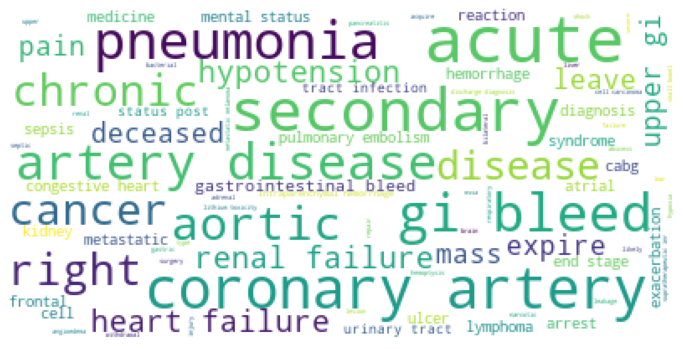

In [112]:
stop_words = default_stop_words()
make_word_cloud(df['label_candidate'], stop_words=stop_words)

In [113]:
get_top_ngram(df['label_candidate'], ngram=1, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [114]:
get_top_ngram(df['label_candidate'], ngram=2, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [115]:
get_top_ngram(df['label_candidate'], ngram=3, top_n=20, stop_words=stop_words)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



## 7.2 LDA with grid search on label_candidate
* first round using grid search, optimal number of topics is 10, but they are really overlapping
* force to 20 topics. still overlap

In [116]:
lc_lda_output = do_vectorization_lda(df['label_candidate'], n_components=20, stop_words=stop_words, max_features=2000)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



Sparsicity:  0.6213627759364422 %


In [117]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(lc_lda_output)
panel

PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
12    -33.620071  47.102676       1        1  7.965784
9      41.150177 -26.973192       2        1  6.457350
2      45.057590  52.097462       3        1  6.282292
3     -37.826874 -24.480431       4        1  6.228172
4     -76.603790 -24.199739       5        1  6.110689
16    -56.730297 -66.504623       6        1  5.843787
1     -60.394871  15.669237       7        1  5.721676
8      15.627155  -0.680236       8        1  5.382310
17     20.310135 -56.589233       9        1  5.217388
18    -19.040030 -59.263744      10        1  4.797925
13      3.422625  71.218941      11        1  4.681160
10     81.456810 -18.574137      12        1  4.612495
15     83.152069  25.984791      13        1  4.447441
14     38.483471 -90.598244      14        1  4.347568
5      -1.729906 -28.185240      15        1  4.120126
0     -20.580357   7.615136      16        1  3.992556
6      47.816383  10.908095      17        1  3.660714
7      67.186325 -58.257111      18        1  3.627956
19     -7.045159 -95.316544      19        1  3.429274
11      8.115211  32.874847      20        1  3.073333, topic_info=               Term       Freq      Total Category  logprob  loglift
56            bleed  11.000000  11.000000  Default  30.0000  30.0000
178         failure  10.000000  10.000000  Default  29.0000  29.0000
111        coronary   7.000000   7.000000  Default  28.0000  28.0000
37           artery   8.000000   8.000000  Default  27.0000  27.0000
209      hemorrhage   5.000000   5.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
164       epistaxis   0.028952   1.273612  Topic20  -6.8554  -0.3016
73   cardiomyopathy   0.028952   2.015100  Topic20  -6.8554  -0.7604
389       secondary   0.028952   8.086338  Topic20  -6.8554  -2.1499
174          expire   0.028952   3.997171  Topic20  -6.8554  -1.4453
400             sir   0.028952   1.321263  Topic20  -6.8554  -0.3383

[752 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         8  0.758061         aaa
1         7  0.758300      abcess
2        14  0.786148   abdominal
3        13  0.771199    ablation
4         7  0.384975     abscess
...     ...       ...         ...
466       1  0.732330        week
467      11  0.389448  withdrawal
467      18  0.389448  withdrawal
468       8  0.525205       wound
468      19  0.525205       wound

[653 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 10, 3, 4, 5, 17, 2, 9, 18, 19, 14, 11, 16, 15, 6, 1, 7, 8, 20, 12])

In [118]:
lc_lda_metrics = evalute_lda(lc_lda_output)
lc_lda_metrics['df_document_topic_top']

In [119]:
lc_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0           0             23
1           3             21
2          12             20
3           9             19
4           2             18
5           1             17
6          14             16
7           5             16
8          16             15
9          18             15
10          8             15
11          4             15
12         10             14
13         17             13
14         19             13
15         15             12
16         13             11
17          7             11
18         11             10
19          6              9

In [120]:
lc_lda_metrics['df_topic_keywords']

Word 0               Word 1            Word 2      Word 3  \
Topic 0     angioedema               status              cell       acute   
Topic 1   exacerbation             lymphoma              mssa        copd   
Topic 2         artery             coronary           disease        cabg   
Topic 3          bleed                upper  gastrointestinal   secondary   
Topic 4      infection                tract           urinary       shock   
Topic 5       deceased               status            mental         inr   
Topic 6         lesion            pneumonia             liver  aspiration   
Topic 7   pancreatitis               severe        anaplastic    effusion   
Topic 8         expire              chronic         diagnosis       acute   
Topic 9        failure                renal             acute     hypoxia   
Topic 10         heart              failure          medicine  congestive   
Topic 11     pneumonia                  low        healthcare  associated   
Topic 12    metastatic               cancer       hypotension      injury   
Topic 13         acute            secondary        withdrawal    narcotic   
Topic 14          vein  choledocholithiasis         neurology  hemoptysis   
Topic 15        atrial             toxicity           lithium     femoral   
Topic 16        arrest                small            aortic       bowel   
Topic 17        aortic                 type             right  dissection   
Topic 18     pulmonary             embolism              pain       chest   
Topic 19    hemorrhage     intraparenchymal            sepsis        left   

                    Word 4       Word 5          Word 6           Word 7  \
Topic 0          diagnosis       anemia          cancer            blood   
Topic 1             asthma      abscess      meningitis        vertebral   
Topic 2            surgery   transplant     hypotension       cellulitis   
Topic 3              ulcer    diagnosis    hyponatremia            alter   
Topic 4             septic      seizure        syndrome   cardiomyopathy   
Topic 5   supratherapeutic      altered  tracheomalacia          abscess   
Topic 6               cell     reaction       carcinoma           likely   
Topic 7                hcv    malignant          repair         lymphoma   
Topic 8       hypertensive    emergency          kidney            renal   
Topic 9        respiratory      adrenal    ketoacidosis         diabetic   
Topic 10      intoxication    diastolic           nsaid            ulcer   
Topic 11     osteomyelitis        right     bradycardia       thrombosis   
Topic 12              cell       status            post             mass   
Topic 13           acquire    cirrhosis      multifocal        pneumonia   
Topic 14              mass       atrial      idiopathic         aneurysm   
Topic 15             graft  hypotension        syndrome             pain   
Topic 16           leakage     stenosis     obstruction  cardiopulmonary   
Topic 17             leave    arthritis            high           tibial   
Topic 18              mass    placement           brain              ivc   
Topic 19          bleeding         knee    subarachnoid   frontotemporal   

                  Word 8        Word 9         Word 10         Word 11  \
Topic 0             lung   epilepticus         myeloma          change   
Topic 1         reaction      epidural         passive          peanut   
Topic 2        unremitte  superimposed       pneumovax      lymphedema   
Topic 3        excessive      squamous          throat  hypopharyngeal   
Topic 4          require          coli        systemic          cystic   
Topic 5       hemoptysis           nos           fluid      collection   
Topic 6            colon           non       recurrent       extensive   
Topic 7           cancer          arch  pseudoaneurysm        endoleak   
Topic 8            leave     bilateral       discharge           wound   
Topic 9       infarction     bacterial       secondary       

In [121]:
lc_lda_metrics['df_topic_keywords_matrix']

aaa  abcess  abdominal  ablation  abscess  acomm  acquire     acute  \
Topic0   0.05    0.05       0.05      0.05     0.05   0.05     0.05  1.050000   
Topic1   0.05    1.05       0.05      0.05     1.05   0.05     0.05  0.050000   
Topic2   0.05    0.05       0.05      0.05     0.05   0.05     0.05  1.050000   
Topic3   0.05    0.05       0.05      0.05     0.05   0.05     0.05  1.050000   
Topic4   0.05    0.05       0.05      0.05     0.05   0.05     0.05  1.050000   
Topic5   0.05    0.05       0.05      0.05     1.05   1.05     0.05  0.050000   
Topic6   0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic7   0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic8   1.05    0.05       0.05      0.05     1.05   0.05     0.05  2.388885   
Topic9   0.05    0.05       0.05      0.05     0.05   0.05     0.05  4.330845   
Topic10  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic11  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic12  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic13  0.05    0.05       0.05      0.05     0.05   0.05     2.05  2.430270   
Topic14  0.05    0.05       1.05      0.05     0.05   0.05     0.05  1.050000   
Topic15  0.05    0.05       0.05      1.05     0.05   0.05     1.05  0.050000   
Topic16  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic17  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic18  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   
Topic19  0.05    0.05       0.05      0.05     0.05   0.05     0.05  0.050000   

         additional  adenoma  ...  vancomycin  vasopressor  vein  venous  \
Topic0         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic1         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic2         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic3         1.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic4         0.05     0.05  ...        0.05         1.05  0.05    0.05   
Topic5         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic6         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic7         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic8         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic9         0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic10        0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic11        0.05     0.05  ...        0.05         0.05  0.05    1.05   
Topic12        0.05     1.05  ...        0.05         0.05  0.05    0.05   
Topic13        0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic14        0.05     0.05  ...        0.05         0.05  2.05    0.05   
Topic15        0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic16        0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic17        0.05     0.05  ...        0.05         0.05  0.05    0.05   
Topic18        0.05     0.05  ...        1.05         0.05  0.05    0.05   
Topic19        0.05     0.05  ...        0.05         0.05  0.05    0.05   

         ventricular  vertebral  vocal  week  withdrawal  wound  
Topic0          0.05       0.05   0.05  0.05        0.05   0.05  
Topic1          0.05       1.05   0.05  0.05        0.05   0.05  
Topic2          0.05       0.05   0.05  0.05        0.05   0.05  
Topic3          0.05       0.05   0.05  0.05        0.05   0.05  
Topic4          0.05       0.05   0.05  0.05        0.05   0.05  
Topic5          0.05       0.05   0.05  0.05        0.05   0.05  
Topic6          0.05       0.05   0.05  0.05        0.05   0.05  
Topic7          0.05       0.05   0.05  0.05        1.05   0.05  
Topic8          0.05       0.05   0.05  0.05        0.05   1.05  
Topic9          0.05       0.05   0.05  0.05       

## 7.3 make predictions

In [122]:
my_data = df['label_candidate'][4]
topic, prob_scores = predict_topic(my_data, lc_lda_output, lc_lda_metrics)
print(my_data)
print(topic)
print(prob_scores)

    deep vein thrombosis of subclavian vein
['vein', 'choledocholithiasis', 'neurology', 'hemoptysis', 'mass', 'atrial', 'idiopathic', 'aneurysm', 'ventricular', 'frontal', 'fibrillation', 'rapid', 'deep', 'response', 'subclavian', 'thoracic', 'edh', 'afib', 'thrombocytopenic', 'ivh']
[[0.00833333 0.00833333 0.00833333 0.00833333 0.00833333 0.00833333
  0.00833333 0.00833333 0.00833333 0.00833333 0.00833333 0.00833333
  0.00833333 0.00833333 0.84166667 0.00833333 0.00833333 0.00833333
  0.00833333 0.00833333]]


## 7.6 forced lda on label_candidate n_component = 30
* promising, topics are much more focal!

In [123]:
stop_words = default_stop_words()
data_vectorized, vectorizer = get_data_vectorized(df['label_candidate'],stop_words=stop_words)

Sparsicity:  0.6213627759364422 %


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [126]:
lc_30_lda_output = do_vectorization_lda(df['label_candidate'], n_components=30, stop_words=stop_words, max_features=10000)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



Sparsicity:  0.6213627759364422 %


In [127]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(lc_30_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
6      101.035736  -18.005407       1        1  6.812037
2     -128.744308  -28.716610       2        1  5.438051
17     -49.034206 -105.307526       3        1  5.392253
24      -9.278448  -76.277138       4        1  4.114023
20      17.873087   72.824150       5        1  3.902582
1      -50.374176  -14.952868       6        1  3.812143
16     -36.866772  102.708176       7        1  3.806594
19     -94.521301  -84.536041       8        1  3.774324
27      65.549973   90.467537       9        1  3.699221
13     -45.831772  -58.498020      10        1  3.530757
0       16.421625   29.717056      11        1  3.528772
5      -92.435593    1.794861      12        1  3.457663
10     -93.974495   85.856712      13        1  3.402800
14     -14.390483  -29.766846      14        1  3.342078
11      99.127647   34.684628      15        1  3.318166
9     -113.575577   39.042011      16        1  3.302928
8       20.866318  -50.662838      17        1  2.919951
22      19.161856   -9.133847      18        1  2.891987
15     -57.846695   24.439390      19        1  2.887193
28     -18.663155   54.237041      20        1  2.845123
21     -58.189590   62.678383      21        1  2.819147
12       0.998342 -120.249290      22        1  2.641108
26      40.671940  -91.219055      23        1  2.615940
23     -18.954670   11.983274      24        1  2.563741
4       10.052206  115.707855      25        1  2.540437
25      57.328262  -35.761581      26        1  2.359314
3       58.035965    5.672841      27        1  2.358048
7       54.381393   46.724354      28        1  2.089281
29     -83.537491  -41.100830      29        1  1.973430
18      84.747749  -71.413513      30        1  1.860907, topic_info=                Term       Freq      Total Category  logprob  loglift
56             bleed  11.000000  11.000000  Default  30.0000  30.0000
178          failure  11.000000  11.000000  Default  29.0000  29.0000
134          disease  10.000000  10.000000  Default  28.0000  28.0000
111         coronary   7.000000   7.000000  Default  27.0000  27.0000
37            artery   8.000000   8.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
160  enterocutaneous   0.019367   1.252719  Topic30  -6.7558  -0.1854
161         epidural   0.019367   1.320459  Topic30  -6.7558  -0.2380
162      epilepticus   0.019367   1.831029  Topic30  -6.7558  -0.5649
163          episode   0.019367   1.294448  Topic30  -6.7558  -0.2181
164        epistaxis   0.019367   1.289811  Topic30  -6.7558  -0.2146

[1249 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         3  0.746454         aaa
1         3  0.746454      abcess
2        22  0.804426   abdominal
3         9  0.761220    ablation
4         6  0.378065     abscess
...     ...       ...         ...
466       5  0.747705        week
467      12  0.391813  withdrawal
467      18  0.391813  withdrawal
468       7  0.497432       wound
468      15  0.497432       wound

[645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 18, 25, 21, 2, 17, 20, 28, 14, 1, 6, 11, 15, 12, 10, 9, 23, 16, 29, 22, 13, 27, 24, 5, 26, 4, 8, 30, 19])

In [128]:
lc_30_lda_metrics = evalute_lda(lc_30_lda_output)
lc_30_lda_metrics['df_document_topic_top']

In [129]:
lc_30_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0           0             22
1           6             21
2          17             17
3           2             15
4          10             13
5          12             12
6          27             11
7           1             11
8          22             11
9          19             11
10         15             10
11          5             10
12          7             10
13          9             10
14         14             10
15         20             10
16         26             10
17         16              9
18         24              9
19         13              8
20          8              8
21         21              8
22         11              7
23         23              7
24          4              7
25         25              6
26         29              6
27         28              5
28         18              5
29          3              4

In [130]:
lc_30_lda_metrics['df_topic_keywords']

Word 0            Word 1        Word 2  \
Topic 0           respiratory           failure       abscess   
Topic 1                aortic              type          mssa   
Topic 2                artery          coronary       disease   
Topic 3             secondary            kidney       disease   
Topic 4             pulmonary          embolism       acquire   
Topic 5             infection             tract       urinary   
Topic 6               failure             acute         renal   
Topic 7              medicine               low         bleed   
Topic 8                  mass           frontal       blocker   
Topic 9              toxicity           lithium  pancreatitis   
Topic 10               expire         pneumonia    associated   
Topic 11           hemorrhage  intraparenchymal          cell   
Topic 12             deceased            repair      reaction   
Topic 13          hypotension         secondary        cancer   
Topic 14                right             brain          vein   
Topic 15         exacerbation        angioedema        injury   
Topic 16               aortic         bilateral      stenosis   
Topic 17                bleed  gastrointestinal         upper   
Topic 18  choledocholithiasis             right    thrombosis   
Topic 19            diagnosis             ulcer     discharge   
Topic 20               status        metastatic          post   
Topic 21               arrest           disease         liver   
Topic 22               sepsis        withdrawal      narcotic   
Topic 23                shock         pneumonia        septic   
Topic 24                small       obstruction         bowel   
Topic 25               status       epilepticus           hsv   
Topic 26              surgery         pneumonia       leakage   
Topic 27               atrial        hemorrhage      lymphoma   
Topic 28            diastolic             acute          pain   
Topic 29                  inr  supratherapeutic     neurology   

                   Word 3          Word 4          Word 5       Word 6  \
Topic 0           femoral           graft          lesion    extensive   
Topic 1        dissection      hemoptysis       placement    vertebral   
Topic 2              cabg           heart       elevation   myocardial   
Topic 3             stage             end           renal       cystic   
Topic 4          syndrome        systemic            drug       relate   
Topic 5         bacterial         hypoxia        effusion  complicated   
Topic 6           chronic           heart      congestive       lesion   
Topic 7           seizure         adrenal        cataract    mitomycin   
Topic 8         associate            beta          induce       rhythm   
Topic 9      intoxication            mass         hypoxia     aneurysm   
Topic 10       healthcare     obstructive        reaction          pre   
Topic 11           cancer           leave      infarction    carcinoma   
Topic 12         endoleak            arch  pseudoaneurysm        giant   
Topic 13            colon            cell            ring       signet   
Topic 14             cell             non            deep   subclavian   
Topic 15             pain          asthma            copd        chest   
Topic 16            upper           leave           wound       severe   
Topic 17       hemorrhage  tracheomalacia  cardiomyopathy        masth   
Topic 18        extremity             low           iliac       common   
Topic 19            upper         gastric           bleed        nsaid   
Topic 20         melanoma          mental         altered        cycle   
Topic 21  cardiopulmonary   osteomyelitis             end        stage   
Topic 22       anaplastic          likely          hernia        fluid   
Topic 23       multifocal            coli        syndrome      require   
Topic 24         reaction          likely      hemoptysis       tibial   
Topic 25       refractory    encephalitis             ivh          edh   
Topic 26 

In [131]:
lc_30_lda_metrics['df_topic_keywords_matrix']

aaa    abcess  abdominal  ablation   abscess     acomm  \
Topic0   0.033333  0.033333   0.033333  0.033333  2.033333  1.033333   
Topic1   0.033333  0.033333   0.033333  0.033333  1.033333  0.033333   
Topic2   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic3   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic4   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic5   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic6   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic7   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic8   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic9   0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic10  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic11  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic12  0.033333  0.033333   1.033333  0.033333  0.033333  0.033333   
Topic13  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic14  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic15  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic16  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic17  1.033333  1.033333   0.033333  0.033333  0.033333  0.033333   
Topic18  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic19  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic20  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic21  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic22  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic23  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic24  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic25  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic26  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic27  0.033333  0.033333   0.033333  1.033333  0.033333  0.033333   
Topic28  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   
Topic29  0.033333  0.033333   0.033333  0.033333  0.033333  0.033333   

          acquire      acute  additional   adenoma  ...  vancomycin  \
Topic0   1.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic1   0.033333   1.033333    0.033333  0.033333  ...    0.033333   
Topic2   0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic3   0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic4   1.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic5   0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic6   0.033333  10.974774    0.033333  0.033333  ...    0.033333   
Topic7   0.033333   0.033333    0.033333  1.033333  ...    0.033333   
Topic8   0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic9   0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic10  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic11  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic12  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic13  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic14  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic15  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic16  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic17  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic18  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic19  1.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic20  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic21  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic22  0.033333   1.033333    0.033333  0.033333  ...    0.033333   
Topic23  0.033333   0.033333    0.033333  0.033333  ...    0.033333   
Topic2

In [132]:
my_data = df['label_candidate'][2]
topic, prob_scores = predict_topic(my_data, lc_30_lda_output, lc_30_lda_metrics)
print(my_data)
print(topic)
print(prob_scores)

    pulmonary embolism with history of dvt and ivc filter
['hemorrhage', 'intraparenchymal', 'cell', 'cancer', 'leave', 'infarction', 'carcinoma', 'history', 'dvt', 'ivc', 'filter', 'throat', 'squamous', 'hypopharyngeal', 'intraventricular', 'significance', 'unclear', 'stab', 'pulmonary', 'wound']
[[0.0047619  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619
  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619  0.86190476
  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619
  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619
  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619  0.0047619 ]]


In [185]:
# add topics and keywods and observe
# observation, categorization is not great
df = df.drop(columns='dominant_topic','topic_top_10_keywords')
df = add_topic_keywords_to_df(df, lc_30_lda_metrics)

SyntaxError: positional argument follows keyword argument (<ipython-input-185-18a5228d5003>, line 3)

In [186]:
df[['label_candidate', 'dominant_topic', 'topic_top_10_keywords']][0:20]

label_candidate  dominant_topic  \
0                anoxic brain injury s p pea arrest                13   
1                                      abdominal pain               7   
2       pulmonary embolism with history of dvt and...               8   
3                                              sepsis              21   
4             deep vein thrombosis of subclavian vein               7   
5                     healthcare associated pneumonia              35   
6     alter mental status secondary to excessive n...              25   
7                          malignant pleural effusion              10   
8                               diabetic ketoacidosis              38   
9   discharge diagnosis    chronic obstructive pul...              31   
10              disseminate intravascular coagulation              10   
11                     pneumonia   pulmonary embolism              17   
12                                                n a               0   
13  type a aortic dissection   aortic insufficienc...               4   
14                           metastatic rectal cancer              34   
15                                   hypothyroidism                39   
16                             vocal cord dysfunction              24   
17      korsakoff s psychosis   back pain   agitation              30   
18                                                ccu               9   
19                                      jejunal ulcer              35   

                                topic_top_10_keywords  
0   arrest,anoxic,brain,injury,pea,non,cancer,lung...  
1   pneumonia,multifocal,atrial,rapid,ventricular,...  
2   inr,supratherapeutic,antral,secondary,erosion,...  
3   sepsis,aortic,repair,arch,endoleak,pseudoaneur...  
4   pneumonia,multifocal,atrial,rapid,ventricular,...  
5   cancer,carcinoma,cell,pneumonia,associated,hea...  
6   bleeding,secondary,status,excessive,alter,narc...  
7   withdrawal,narcotic,delirium,likely,acute,seco...  
8   failure,heart,diastolic,diabetic,ketoacidosis,...  
9   diagnosis,discharge,status,obstructive,chronic...  
10  withdrawal,narcotic,delirium,likely,acute,seco...  
11  embolism,pulmonary,pneumonia,cirrhosis,stage,h...  
12  deceased,aaa,neuroleptic,necrotize,necrosis,ne...  
13  aortic,type,repair,dissection,insufficiency,ns...  
14  syndrome,thrombosis,iliac,extremity,venous,com...  
15  chronic,injury,kidney,lung,obstructive,disease...  
16  induce,pre,prolonged,rhythm,cardiology,blocker...  
17  hemoptysis,tracheomalacia,non,carcinoma,metast...  
18  osteomyelitis,pain,cellulitis,unremitte,lymphe...  
19  cancer,carcinoma,cell,pneumonia,associated,hea...

In [188]:
# write output to a file
output = df[['id','chief_complaint_preprocessed','first_diagnosis_preprocessed','label_candidate','dominant_topic', 'topic_top_10_keywords']]
output.to_csv('topic_predicted.csv', index=False)

# 7.7 try n_components = 40 to see whether it is able to separate the topics further up
## a little too fine. go with n_components=30

In [168]:
stop_words = default_stop_words()
#data_vectorized, vectorizer = get_data_vectorized(df['label_candidate'],stop_words=stop_words, max_features=1000)

In [169]:
data = df['label_candidate']
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                         # minimum requied occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=1000,             # max number of unique words
                             binary=True,
                            )

data_vectorized = vectorizer.fit_transform(data)
    # Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.6213627759364422 %


/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['admission', 'birth', 'brief', 'chief', 'complaint', 'condition', 'course', 'data', 'date', 'diagnosis', 'discharge', 'exam', 'examination', 'family', 'followup', 'history', 'hospital', 'illness', 'instruction', 'invasive', 'laboratory', 'major', 'medical', 'medication', 'past', 'pertinent', 'physical', 'present', 'procedure', 'result', 'social', 'summary', 'surgical'] not in stop_words.



In [170]:
data_vectorized.shape

(303, 469)

In [171]:
search_params = {'n_components': [40],
                 'learning_decay': [.5, .6, .7, .8, .9],
                'batch_size': [64],
                'learning_offset': [5,10],
                'max_iter': [10],
                'max_doc_update_iter': [100]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized)
best_lda_model = model.best_estimator_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



In [172]:
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'batch_size': 64, 'learning_decay': 0.9, 'learning_offset': 10, 'max_doc_update_iter': 100, 'max_iter': 10, 'n_components': 40}
Best Log Likelihood Score:  -9551.16975422812
Model Perplexity:  1665.4332981184532


In [173]:
lc_40_lda_output = dict()
lc_40_lda_output['best_lda_model'] = best_lda_model
lc_40_lda_output['model'] = model
lc_40_lda_output['data_vectorized'] = data_vectorized
lc_40_lda_output['vectorizer'] = vectorizer

In [174]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(lc_40_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
36     143.589279  -47.292484       1        1  5.817831
14     -80.413940  112.133705       2        1  4.614167
2       67.797028  111.584015       3        1  4.192613
15    -139.755905   37.358799       4        1  3.764095
11     119.920578   81.555504       5        1  3.607886
22      -1.676723  140.565247       6        1  3.355685
24      56.417339 -102.441330       7        1  3.179967
34     -39.545589  -86.068077       8        1  3.131566
29     119.697220   30.815639       9        1  3.097485
4       14.548540 -132.778839      10        1  3.047572
16     -28.916006   95.697998      11        1  2.963084
8      -93.638138   43.377594      12        1  2.825116
12      73.639076   25.288700      13        1  2.727775
33     -53.402393 -127.182404      14        1  2.641758
32    -112.116318  -14.369091      15        1  2.627602
10      24.490446  101.428520      16        1  2.622074
13     -84.304527  -68.509331      17        1  2.594571
17     102.437233  -14.753468      18        1  2.557764
35     -70.025848  -32.361191      19        1  2.440874
31     -65.409531   65.076782      20        1  2.425943
18      46.911003   62.747520      21        1  2.309558
28      82.332283  -65.150665      22        1  2.250775
38      89.659470   61.768353      23        1  2.248348
30      -5.192051  -54.079594      24        1  2.201970
7        7.333578  -88.547615      25        1  2.151007
37     -40.706184  -51.201504      26        1  2.084944
25       5.454222   67.332359      27        1  2.053935
27     -69.055550    6.426690      28        1  2.005669
3       37.052238  -62.218750      29        1  1.930169
39     -32.228008   56.834728      30        1  1.928282
21      72.682510  -24.407169      31        1  1.896194
6       47.888096    3.665094      32        1  1.835794
9       32.854542  -31.953817      33        1  1.811256
19     -38.121487   20.776186      34        1  1.673468
23      -4.232637   34.515625      35        1  1.633831
5       30.002316   35.393642      36        1  1.350705
20     -32.150955  -15.103486      37        1  1.288417
26       0.809373  -22.162655      38        1  1.250667
1       17.408558    3.924371      39        1  0.995854
0       -9.618751    5.708119      40        1  0.863729, topic_info=              Term     Freq      Total Category  logprob  loglift
56           bleed  11.0000  11.000000  Default  30.0000  30.0000
178        failure  10.0000  10.000000  Default  29.0000  29.0000
111       coronary   8.0000   8.000000  Default  28.0000  28.0000
37          artery   8.0000   8.000000  Default  27.0000  27.0000
7            acute  10.0000  10.000000  Default  26.0000  26.0000
..             ...      ...        ...      ...      ...      ...
170  esosinophilia   0.0114   1.381177  Topic40  -6.5058  -0.0454
171   exacerbation   0.0114   3.315796  Topic40  -6.5058  -0.9212
172  exascerbation   0.0114   1.332745  Topic40  -6.5058  -0.0097
147       elective   0.0114   1.332745  Topic40  -6.5058  -0.0097
145            edh   0.0114   1.389409  Topic40  -6.5058  -0.0513

[1802 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        36  0.843417         aaa
1         5  0.747191      abcess
2        25  0.796914   abdominal
3         2  0.719730    ablation
4         2  0.365144     abscess
...     ...       ...         ...
466       2  0.719730        week
467       6  0.377668  withdrawal
467      16  0.377668  withdrawal
468      11  0.519874       wound
468      29  0.519874       wound

[670 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[37, 15, 3, 16, 12, 23, 25, 35, 30, 5, 17, 9, 13, 34, 33, 11, 14, 18, 36, 32, 19, 29, 39, 31, 8, 38, 26, 28, 4, 40, 22, 7, 10, 20, 24, 6, 21, 27, 2, 1])

In [175]:
lc_40_lda_metrics = evalute_lda(lc_40_lda_output)
lc_40_lda_metrics['df_document_topic_top']

In [176]:
lc_40_lda_metrics['df_topic_distribution']

Topic Num  Num Documents
0           0             17
1          15             16
2          36             14
3          22             11
4           4             10
5          11             10
6          12              9
7          18              9
8          28              9
9          24              8
10          3              8
11         14              8
12         39              8
13         32              8
14         13              7
15          7              7
16          8              7
17          9              7
18         34              7
19         33              7
20         37              7
21         16              7
22         30              7
23         21              7
24         29              7
25          2              7
26         17              6
27         31              6
28         38              6
29         20              6
30         10              6
31         27              6
32         35              6
33          5              5
34         26              5
35          6              5
36         25              5
37         19              5
38          1              4
39         23              3

In [177]:
lc_40_lda_metrics['df_topic_keywords']

Word 0            Word 1            Word 2         Word 3  \
Topic 0          deceased               aaa       neuroleptic      necrotize   
Topic 1         neurology          lymphoma     lymphoblastic     anaplastic   
Topic 2             acute            anemia            artery         tibial   
Topic 3              pain             chest         pneumovax      secondary   
Topic 4            aortic              type            repair     dissection   
Topic 5              mass           adrenal   retroperitoneal        episode   
Topic 6             bowel             small       obstruction    epilepticus   
Topic 7         pneumonia        multifocal            atrial          rapid   
Topic 8               inr  supratherapeutic            antral      secondary   
Topic 9     osteomyelitis              pain        cellulitis      unremitte   
Topic 10       withdrawal          narcotic          delirium         likely   
Topic 11            acute             renal           failure        chronic   
Topic 12          failure       respiratory            status         mental   
Topic 13           arrest            anoxic             brain         injury   
Topic 14           status              post          melanoma     metastatic   
Topic 15            bleed             upper  gastrointestinal      secondary   
Topic 16            wound           buttock         extremity          leave   
Topic 17         embolism         pulmonary         pneumonia      cirrhosis   
Topic 18            right           surgery           frontal          brain   
Topic 19            death             chief           librium          cause   
Topic 20         medicine    trabeculectomy          cataract      mitomycin   
Topic 21           sepsis            aortic            repair           arch   
Topic 22     exacerbation            asthma              copd   pancreatitis   
Topic 23        resistant      enterococcus        vancomycin     bacteremia   
Topic 24           induce               pre         prolonged         rhythm   
Topic 25         bleeding         secondary            status      excessive   
Topic 26              hcv               hcc            hernia          giant   
Topic 27      hypotension              ring            injury       dialysis   
Topic 28           expire          stenosis            aortic     sternotomy   
Topic 29            heart        congestive           failure        adrenal   
Topic 30       hemoptysis    tracheomalacia               non      carcinoma   
Topic 31        diagnosis         discharge            status    obstructive   
Topic 32         toxicity           lithium        angioedema          stage   
Topic 33            tract         infection           urinary      bacterial   
Topic 34         syndrome        thrombosis             iliac      extremity   
Topic 35           cancer         carcinoma              cell      pneumonia   
Topic 36           artery          coronary           disease           cabg   
Topic 37  cardiopulmonary            arrest           hypoxia  erythematosus   
Topic 38          failure             heart         diastolic       diabetic   
Topic 39          chronic            injury            kidney           lung   

                     Word 4               Word 5        Word 6  \
Topic 0            necrosis                 neck      narcotic   
Topic 1         astrocytoma                  aaa   neuroleptic   
Topic 2               right             anterior   angiography   
Topic 3             blocker                 beta   hypotension   
Topic 4       insufficiency                nsaid      thoracic   
Topic 5             frontal          hypotensive           aaa   
Topic 6      leukodystrophy               status      lymphoma   
Topic 7         ventricular             response  fibrillation   
Topic 8             erosion                bleed      embolism   
Topic 9          lymphedema         superimposed   bradycardia   
Topic 10    

In [178]:
lc_40_lda_metrics['df_topic_keywords_matrix']

aaa  abcess  abdominal  ablation  abscess  acomm  acquire  acute  \
Topic0   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic1   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic2   0.025   0.025      0.025     0.025    0.025  0.025    0.025  3.025   
Topic3   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic4   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic5   1.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic6   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic7   0.025   0.025      1.025     0.025    0.025  0.025    0.025  0.025   
Topic8   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic9   0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic10  0.025   0.025      0.025     0.025    0.025  0.025    0.025  1.025   
Topic11  0.025   1.025      0.025     0.025    0.025  0.025    0.025  6.025   
Topic12  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic13  0.025   0.025      0.025     0.025    1.025  0.025    0.025  0.025   
Topic14  0.025   0.025      0.025     1.025    1.025  0.025    0.025  0.025   
Topic15  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic16  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic17  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic18  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic19  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic20  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic21  0.025   0.025      0.025     0.025    0.025  0.025    0.025  1.025   
Topic22  0.025   0.025      0.025     0.025    0.025  0.025    0.025  1.025   
Topic23  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic24  0.025   0.025      0.025     0.025    1.025  0.025    0.025  0.025   
Topic25  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic26  0.025   0.025      0.025     0.025    0.025  1.025    0.025  0.025   
Topic27  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic28  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic29  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic30  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic31  0.025   0.025      0.025     0.025    0.025  0.025    1.025  0.025   
Topic32  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic33  0.025   0.025      0.025     0.025    0.025  0.025    1.025  0.025   
Topic34  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic35  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic36  0.025   0.025      0.025     0.025    0.025  0.025    0.025  0.025   
Topic37  0.025   0.025      0.025     0.025    0.025  0.025    1.025  0.025   
Topic38  0.025   0.025      0.025     0.025    0.025  0.025    0.025  1.025   
Topic39  0.025   0.025      0.025     0.025    0.025  0.025    0.025  1.025   

         additional  adenoma  ...  vancomycin  vasopressor   vein  venous  \
Topic0        0.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic1        0.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic2        1.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic3        0.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic4        0.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic5        0.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic6        0.025    0.025  ...       0.025        0.025  0.025   0.025   
Topic7        0.025    0.025  ...       0.025        0.025  1.025   0.025   
Topic8        0.025    0.025  ...       0.025        0.025  0.025   0.025   
T

In [179]:
my_data = df['label_candidate'][2]
topic, prob_scores = predict_topic(my_data, lc_40_lda_output, lc_40_lda_metrics)
print(my_data)
print(topic)
print(prob_scores)

    pulmonary embolism with history of dvt and ivc filter
['inr', 'supratherapeutic', 'antral', 'secondary', 'erosion', 'bleed', 'embolism', 'history', 'dvt', 'pulmonary', 'ivc', 'filter', 'arthritis', 'right', 'septic', 'knee', 'emergency', 'diagnosis', 'correct', 'hypertensive']
[[0.00357143 0.00357143 0.00357143 0.00357143 0.00357143 0.00357143
  0.00357143 0.00357143 0.86071429 0.00357143 0.00357143 0.00357143
  0.00357143 0.00357143 0.00357143 0.00357143 0.00357143 0.00357143
  0.00357143 0.00357143 0.00357143 0.00357143 0.00357143 0.00357143
  0.00357143 0.00357143 0.00357143 0.00357143 0.00357143 0.00357143
  0.00357143 0.00357143 0.00357143 0.00357143 0.00357143 0.00357143
  0.00357143 0.00357143 0.00357143 0.00357143]]


In [182]:
#df = df.drop(columns = ['dominant_topic', 'topic_top_10_keywords'] )
df = add_topic_keywords_to_df(df, lc_40_lda_metrics)

In [183]:
t = df[['label_candidate', 'dominant_topic', 'topic_top_10_keywords']]

In [184]:
t[30:60]

label_candidate  dominant_topic  \
30               free air on cxr s p g tube placement              11   
31                      diffuse large b cell lymphoma              28   
32    acute on chronic anemia with guaiac    stool...               2   
33          fall   with finding of      retrolistesis              27   
34               gi bleed secondary to colonic lesion              15   
35                   coronary artery disease s p cabg              36   
36                                 pulmonary embolism              17   
37                                             sepsis              21   
38                                         chest pain               3   
39                           congestive heart failure              29   
40           tramatic leave fibular fx with migration              36   
41                                                                  0   
42             thoracic aortic aneurysm    s p repair               4   
43                                                                  0   
44                                  copd exacerbation              22   
45                                           deceased               0   
46  allergic reaction likely due to peanut   passi...               2   
47  small bowel leakage and cecal leakage enterocu...              12   
48                                  cerebellar lesion               4   
49       umbilical hernia with fluid leakage   stable              36   
50                                         angioedema              32   
51                         mrsa pseudomonas pneumonia               4   
52                                             expire              28   
53                            coronary artery disease              36   
54                                       endocarditis               3   
55                                 ileostomy takedown              39   
56                idiopathic thrombocytopenic purpura              16   
57                            symptomatic bradycardia              24   
58                          gastrointestinal bleeding              15   
59                     neuroleptic malignant syndrome              34   

                                topic_top_10_keywords  
30  acute,renal,failure,chronic,bleed,placement,fr...  
31  expire,stenosis,aortic,sternotomy,replacement,...  
32  acute,anemia,artery,tibial,right,anterior,angi...  
33  hypotension,ring,injury,dialysis,secondary,med...  
34  bleed,upper,gastrointestinal,secondary,aspirat...  
35  artery,coronary,disease,cabg,hemorrhage,intrap...  
36  embolism,pulmonary,pneumonia,cirrhosis,stage,h...  
37  sepsis,aortic,repair,arch,endoleak,pseudoaneur...  
38  pain,chest,pneumovax,secondary,blocker,beta,hy...  
39  heart,congestive,failure,adrenal,disease,renal...  
40  artery,coronary,disease,cabg,hemorrhage,intrap...  
41  deceased,aaa,neuroleptic,necrotize,necrosis,ne...  
42  aortic,type,repair,dissection,insufficiency,ns...  
43  deceased,aaa,neuroleptic,necrotize,necrosis,ne...  
44  exacerbation,asthma,copd,pancreatitis,hyponatr...  
45  deceased,aaa,neuroleptic,necrotize,necrosis,ne...  
46  acute,anemia,artery,tibial,right,anterior,angi...  
47  failure,respiratory,status,mental,altered,chol...  
48  aortic,type,repair,dissection,insufficiency,ns...  
49  artery,coronary,disease,cabg,hemorrhage,intrap...  
50  toxicity,lithium,angioedema,stage,disease,end,...  
51  aortic,type,repair,dissection,insufficiency,ns...  
52  expire,stenosis,aortic,sternotomy,replacement,...  
53  artery,coronary,disease,cabg,hemorrhage,intrap...  
54  pain,chest,pneumovax,secondary,blocker,beta,hy...  
55  chronic,injury,kidney,lung,obstructive,disease...  
56  wound,buttock,extremity,leave,bite,severe,bila...  
57  induce,pre,prolonged,rhythm,cardiology,blocker...  
58  bleed,upper,gastrointestinal,secondary,aspirat...  
59  syndrome,thrombosis,iliac,extremity,venous,com...